<a href="https://colab.research.google.com/github/Murcha1990/ML_AI24/blob/main/Hometasks/Base/AI_HW4_woodenML_base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Домашнее задание 4 (base): древесные алгоритмы**

### **Постановка задачи:**

У вас есть данные о полетах, обладающие следущими характеристиками:
- Для **каждого** клиента известна краткая информация о самом человеке, о типе билета и о рейсе, а также оценки клиента различным аспектам полета.
- Для **некоторых** клиентов известна их удовлетворенность полетом (satisfied или neutral or dissatisfied).

По данным необходимо обучить модель, предсказывающую удовлетворенность клиентов полетом. Итоговые предсказания нужно сделать для клиентов, **для которых ответ неизвестен.**

### **Получение данных:**

Компания держит все данные в облаке Яндекса в Postgresql. Данные разбиты на смысловые таблицы. Чтобы получить данные, вам необходимо подключиться к базе данных и добыть оттуда данные.

### **Оценивание:**

- Как всегда оцениваются как код, так и ответы на вопросы. Если нет одного и/или другого, то часть баллов за соответствующее задание без колебаний снимается.
- Брать код из открытых источников позволительно. Следование культуре цитирования **обязательно.**

### **Баллы:**

Суммарно за задание можно получить 10 основных и 0.7 бонусных баллов.

Оценка за ДЗ = min{ваш балл, 10}

Мягкий дедлайн: 2 февраля 23:59

**Продуктивной и интересной вам работы!**

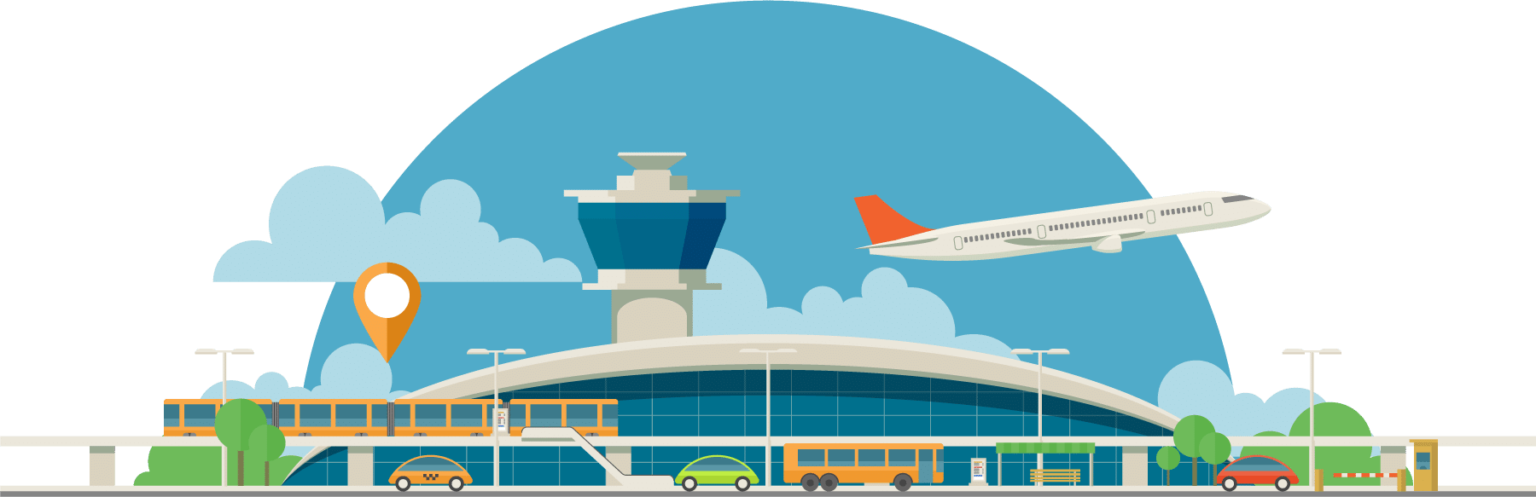

In [1]:
# установка всех библиотек, необходимых для выполнения ДЗ

!pip install catboost
!pip install mlxtend --upgrade
!pip install optuna
!pip install lime
!pip install shap
!pip install missingno
!pip install psycopg2-binary
#!pip install xgboost
#!brew install cmake libomp
#!pip install lightgbm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.4/383.4 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=d46865714d6dae4086532745e3121afb054a963b02dce53435756d6cfcf391da
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 26.6 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import missingno

import psycopg2
import psycopg2.extras

from mlxtend.plotting import plot_decision_regions
from mlxtend.evaluate import bias_variance_decomp
from graphviz import Source
from sklearn.tree import export_graphviz
from IPython.display import SVG

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, RocCurveDisplay
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler
from sklearn.calibration import CalibrationDisplay
from sklearn.isotonic import IsotonicRegression

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2, mutual_info_classif
from sklearn.feature_selection import SequentialFeatureSelector, RFE, SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin, BaseEstimator

import shap
import lime
import lime.lime_tabular

import optuna

import pickle

np.random.seed(42)

/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


# **Часть 1: Получение данных, обработка и EDA (2.75 балла)**

В этой части вам необходимо:
- Загрузить данные из БД и предобработать их (1.75 бала)
- Провести разведочный анализ данных (1. балл)

## **1. 1. Загрузка и предобработка данных (1.75 балла)**

In [3]:
!mkdir -p ~/.postgresql && \
wget "https://storage.yandexcloud.net/cloud-certs/CA.pem" \
    --output-document ~/.postgresql/root.crt && \
chmod 0600 ~/.postgresql/root.crt

--2025-02-09 23:54:34--  https://storage.yandexcloud.net/cloud-certs/CA.pem
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3579 (3.5K) [application/x-x509-ca-cert]
Saving to: ‘/root/.postgresql/root.crt’

/root/.postgresql/r 100%[===================>]   3.50K  --.-KB/s    in 0s      

2025-02-09 23:54:35 (1.62 GB/s) - ‘/root/.postgresql/root.crt’ saved [3579/3579]



### **Задание 1. Получение данных (0.5 балла)**

- Подключитесь к БД при помощи `psycopg2.connect()`
- Напишите SQL-запрос, объединяющий 3 нужные таблицы в одну
- Результат запроса поместите в `pd.DataFrame`. Индексом получившегося датафрейма сделайте столбец 'id'.

Список столбцов таблиц добудьте самостоятельно.


**Примечание:**
 Не забудьте закрыть соединение. Или открывайте соединение, используя менеджер контекста `with as`, который закроет его автоматически

##### **Параметры соединения:**
```
host=rc1b-70q90cunwkzx49mj.mdb.yandexcloud.net
port=6432
sslmode=verify-full
dbname=db_flights
user=mlhs_student
password=mlhs_student
target_session_attrs=read-write```
```

##### **Схема БД**

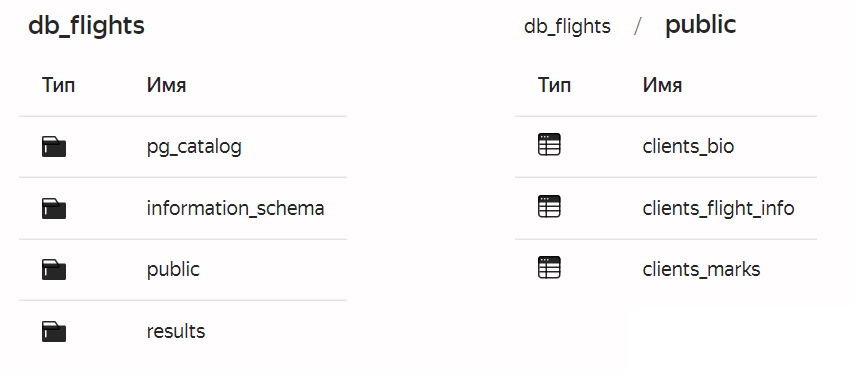



Чтобы писать запрос на объеденение таблиц, для начала посмотрю на содержимое самих таблиц, выведя 5 строчек каждой

In [4]:
params = {
    "host":"rc1b-70q90cunwkzx49mj.mdb.yandexcloud.net",
    "port":"6432",
    "sslmode":"verify-full",
    "dbname":"db_flights",
    "user":"mlhs_student",
    "password":"mlhs_student",
    "target_session_attrs":"read-write"
}
tables = ["clients_bio", "clients_flight_info", "clients_marks"]

with psycopg2.connect(**params) as conn:
    all_data = {}
    with conn.cursor() as cur:
        for table in tables:
            cur.execute(f"select * from {table} limit 5")
            data = cur.fetchall()
            # print(data)
            cols = [desc[0] for desc in cur.description]
            all_data[table] = pd.DataFrame(data, columns=cols)

    for table, df in all_data.items():
        print(f"{table}")
        display(df)

clients_bio


id  gender   age
0   1    Male  48.0
1   2  Female  35.0
2   3    Male  41.0
3   4    Male  50.0
4   5  Female  49.0

clients_flight_info


id      Customer Type   Type of Travel     class Flight Distance  \
0   1  disloyal Customer  Business travel  Business           821.0   
1   2     Loyal Customer  Business travel  Business           821.0   
2   3     Loyal Customer  Business travel  Business           853.0   
3   4     Loyal Customer  Business travel  Business          1905.0   
4   5     Loyal Customer  Business travel  Business          3470.0   

  Departure Delay in Minutes Arrival Delay in Minutes  
0                        2.0                      5.0  
1                       26.0                     39.0  
2                        0.0                      0.0  
3                        0.0                      0.0  
4                        0.0                      1.0

clients_marks


id Inflight wifi service Departure/Arrival time convenient  \
0   1                   3.0                               3.0   
1   2                   2.0                               2.0   
2   3                   4.0                               4.0   
3   4                   2.0                               2.0   
4   5                   3.0                               3.0   

  Ease of Online booking Gate location Food and drink Online boarding  \
0                    3.0           3.0            5.0             3.0   
1                    2.0           2.0            3.0             5.0   
2                    4.0           4.0            5.0             5.0   
3                    2.0           2.0            4.0             4.0   
4                    3.0           3.0            4.0             5.0   

  Seat comfort Inflight entertainment On-board service Leg room service  \
0          5.0                    5.0              3.0              2.0   
1          4.0                    5.0              5.0              5.0   
2          5.0                    3.0              3.0              3.0   
3          5.0                    5.0              5.0              5.0   
4          4.0                    3.0              3.0              4.0   

  Baggage handling Checkin service Inflight service cleanliness  \
0              5.0             4.0              5.0         5.0   
1              5.0             3.0              5.0         5.0   
2              3.0             4.0              3.0         5.0   
3              5.0             3.0              5.0         4.0   
4              3.0             3.0              3.0         5.0   

              satisfaction  
0  neutral or dissatisfied  
1                satisfied  
2                satisfied  
3                satisfied  
4                satisfied

In [5]:
query = '''
select *
from clients_bio as cb inner join clients_flight_info as cf on cb.id = cf.id
    inner join clients_marks as cm on cb.id = cm.id
'''
with psycopg2.connect(**params) as conn:
    with conn.cursor() as cur:
        cur.execute(query)
        data = cur.fetchall()
        cols = [desc[0] for desc in cur.description]
        df = pd.DataFrame(data, columns=cols)

display(df)

id  gender   age      id      Customer Type   Type of Travel  \
0            7    Male  43.0       7     Loyal Customer  Business travel   
1           13    Male  24.0      13  disloyal Customer  Business travel   
2           18  Female  61.0      18     Loyal Customer  Personal Travel   
3           31    Male  35.0      31  disloyal Customer  Business travel   
4           39  Female  46.0      39     Loyal Customer  Business travel   
...        ...     ...   ...     ...                ...              ...   
129544  129838  Female  59.0  129838     Loyal Customer  Personal Travel   
129545  129839    Male  61.0  129839     Loyal Customer  Personal Travel   
129546  129846    Male  44.0  129846     Loyal Customer  Personal Travel   
129547  129868    Male  47.0  129868     Loyal Customer  Business travel   
129548  129876    Male  28.0  129876     Loyal Customer  Personal Travel   

           class Flight Distance Departure Delay in Minutes  \
0       Business          1963.0                        0.0   
1            Eco           453.0                       16.0   
2            Eco           821.0                        0.0   
3       Business           212.0                        0.0   
4       Business            67.0                        0.0   
...          ...             ...                        ...   
129544       Eco           308.0                       32.0   
129545       Eco           337.0                        0.0   
129546       Eco           447.0                        0.0   
129547  Eco Plus           447.0                        0.0   
129548  Eco Plus           447.0                        2.0   

       Arrival Delay in Minutes  ...  Online boarding Seat comfort  \
0                           0.0  ...              4.0          5.0   
1                          30.0  ...              2.0          5.0   
2                           0.0  ...              1.0          5.0   
3                           0.0  ...              2.0          2.0   
4                           0.0  ...              5.0          4.0   
...                         ...  ...              ...          ...   
129544                     24.0  ...              5.0          5.0   
129545                      0.0  ...              2.0          3.0   
129546                      0.0  ...              2.0          5.0   
129547                      0.0  ...              3.0          4.0   
129548                      3.0  ...              4.0          1.0   

       Inflight entertainment On-board service Leg room service  \
0                         5.0              5.0              5.0   
1                         5.0              2.0              4.0   
2                         5.0              5.0              2.0   
3                         2.0              4.0              5.0   
4                         4.0              4.0              4.0   
...                       ...              ...              ...   
129544                    3.0              3.0              3.0   
129545                    3.0              4.0              5.0   
129546                    5.0              4.0              2.0   
129547                    4.0              2.0              5.0   
129548                    4.0              5.0              4.0   

       Baggage handling Checkin service Inflight service cleanliness  \
0                   5.0             4.0              5.0         4.0   
1                   4.0             2.0              4.0         5.0   
2                   5.0             5.0              5.0         1.0   
3                   5.0             5.0              4.0         2.0   
4                   4.0             5.0              4.0         5.0   
...                 ...             ...              ...         ...   
129544              3.0             4.0              3.0         4.0   
129545              5.0             5.0              4.0         3.0   
129546              4.0             3.0         

In [6]:
dupl = df.columns[df.columns.duplicated()]
dupl

Index(['id', 'id'], dtype='object')

Зудублировались два раза id, потому что мне было лень отбирать столбцы в селекте. Удалю просто два дубликата из данных

In [7]:
df = df.drop(dupl, axis=1)

In [8]:
len(df.columns)

23

In [9]:
assert df.shape == (129_549, 23)

### **Задание 2 (0.25 балла)**

- Преобразуйте числовые столбцы в `float`. Проверьте, есть ли в датафрейме пропуски и выбросы (в том числе в категориальных признаках)</font>.

In [9]:
df.head(5)

gender   age      Customer Type   Type of Travel     class Flight Distance  \
0    Male  43.0     Loyal Customer  Business travel  Business          1963.0   
1    Male  24.0  disloyal Customer  Business travel       Eco           453.0   
2  Female  61.0     Loyal Customer  Personal Travel       Eco           821.0   
3    Male  35.0  disloyal Customer  Business travel  Business           212.0   
4  Female  46.0     Loyal Customer  Business travel  Business            67.0   

  Departure Delay in Minutes Arrival Delay in Minutes Inflight wifi service  \
0                        0.0                      0.0                   3.0   
1                       16.0                     30.0                   2.0   
2                        0.0                      0.0                   2.0   
3                        0.0                      0.0                   2.0   
4                        0.0                      0.0                   3.0   

  Departure/Arrival time convenient  ... Online boarding Seat comfort  \
0                               3.0  ...             4.0          5.0   
1                               2.0  ...             2.0          5.0   
2                               5.0  ...             1.0          5.0   
3                               2.0  ...             2.0          2.0   
4                               3.0  ...             5.0          4.0   

  Inflight entertainment On-board service Leg room service Baggage handling  \
0                    5.0              5.0              5.0              5.0   
1                    5.0              2.0              4.0              4.0   
2                    5.0              5.0              2.0              5.0   
3                    2.0              4.0              5.0              5.0   
4                    4.0              4.0              4.0              4.0   

  Checkin service Inflight service cleanliness             satisfaction  
0             4.0              5.0         4.0                satisfied  
1             2.0              4.0         5.0  neutral or dissatisfied  
2             5.0              5.0         1.0  neutral or dissatisfied  
3             5.0              4.0         2.0  neutral or dissatisfied  
4             5.0              4.0         5.0                satisfied  

[5 rows x 23 columns]

моя логика: там, где пользователь, ставит оценку какому-либо сервису - это категориальный порядковый столбец (5>4>3>2>1), так что можно это тоже во float первести

In [10]:
num_cols = ['age', 'Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes', 'Inflight wifi service',
'Departure/Arrival time convenient', 'Ease of Online booking','Gate location', 'Food and drink', 'Online boarding', 'Seat comfort',
'Inflight entertainment', 'On-board service', 'Leg room service','Baggage handling', 'Checkin service', 'Inflight service','cleanliness']
df[num_cols] = df[num_cols].astype(float)

пропуски

In [11]:
df.isna().sum()

gender                                 0
age                                  315
Customer Type                          0
Type of Travel                         0
class                                  0
Flight Distance                       94
Departure Delay in Minutes           107
Arrival Delay in Minutes             507
Inflight wifi service                 44
Departure/Arrival time convenient     49
Ease of Online booking                43
Gate location                         37
Food and drink                        50
Online boarding                       46
Seat comfort                          47
Inflight entertainment                45
On-board service                      44
Leg room service                      46
Baggage handling                      48
Checkin service                       42
Inflight service                      63
cleanliness                           37
satisfaction                           0
dtype: int64

выбросы в числовых колонках посмотрим через межквартильный размах

In [11]:
def outliers(df, column):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    return df[(df[column] < lower) | (df[column] > upper)]

for col in num_cols:
    print(f"{col}, num of outliers: {outliers(df, col).shape[0]}")

age, num of outliers: 448
Flight Distance, num of outliers: 3074
Departure Delay in Minutes, num of outliers: 18124
Arrival Delay in Minutes, num of outliers: 17499
Inflight wifi service, num of outliers: 24
Departure/Arrival time convenient, num of outliers: 35
Ease of Online booking, num of outliers: 29
Gate location, num of outliers: 39
Food and drink, num of outliers: 28
Online boarding, num of outliers: 32
Seat comfort, num of outliers: 34
Inflight entertainment, num of outliers: 23
On-board service, num of outliers: 26
Leg room service, num of outliers: 39
Baggage handling, num of outliers: 27
Checkin service, num of outliers: 16103
Inflight service, num of outliers: 39
cleanliness, num of outliers: 25


выбросы в категориальной колонке - это what? по частоте могу посмотреть, но это же не выбросы, [proof](https://stackoverflow.com/questions/62810630/outliers-in-categorical-data)

### **Задание 3 (0.5 балла)**

Воспользуйтесь модулем `missingno` для визуализации пропусков в датафрейме. Постройте:
-  `matrix` пропущенных значений;
- столбчатую диаграмму в **логарифмированной** шкале (так как пропусков немного, по обычной не будет видно, в каких столбцах их больше)

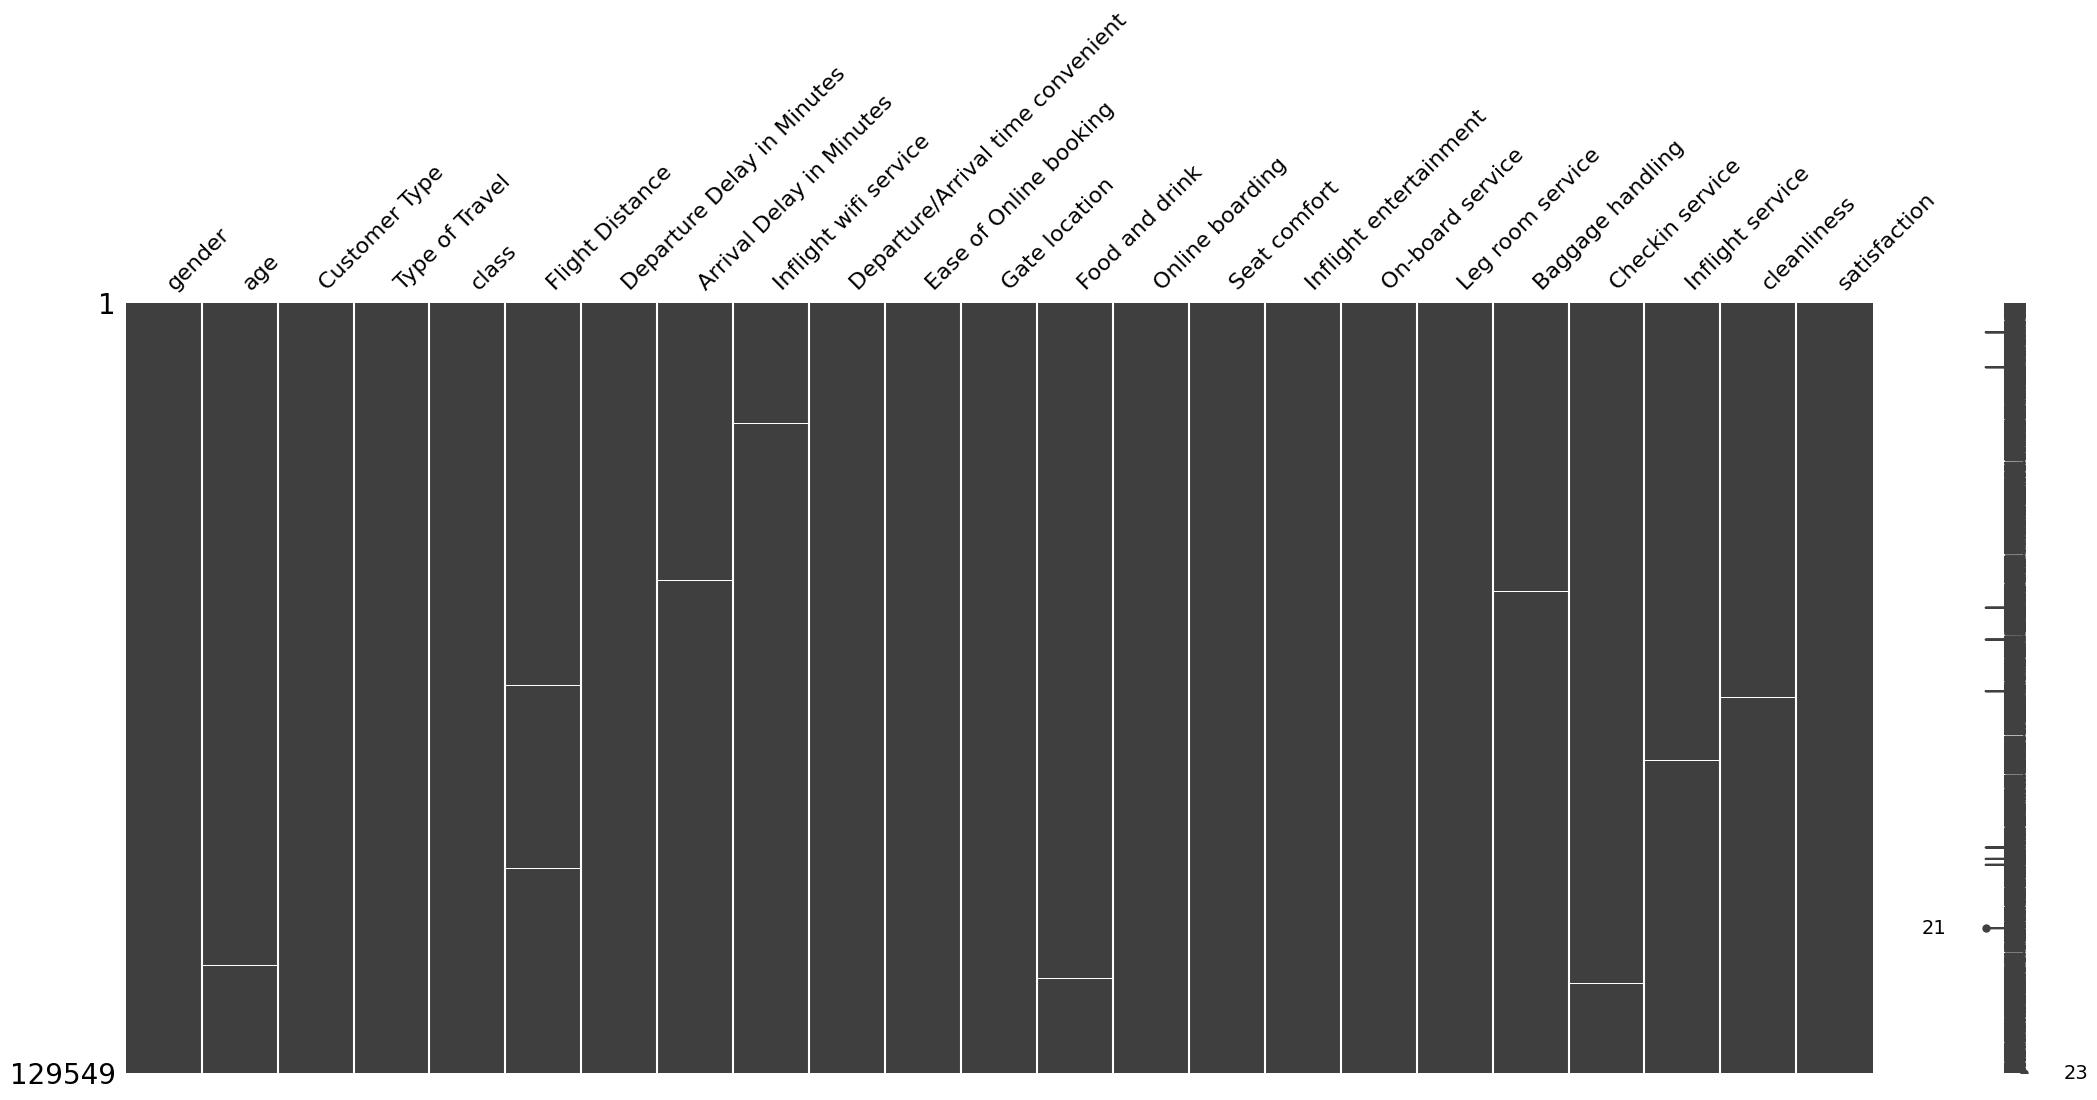

In [13]:
# Ваш код ниже
missingno.matrix(df)
plt.show()

/usr/local/lib/python3.11/dist-packages/missingno/missingno.py:271: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([int(n * len(df)) for n in ax1.get_yticks()], fontsize=fontsize)


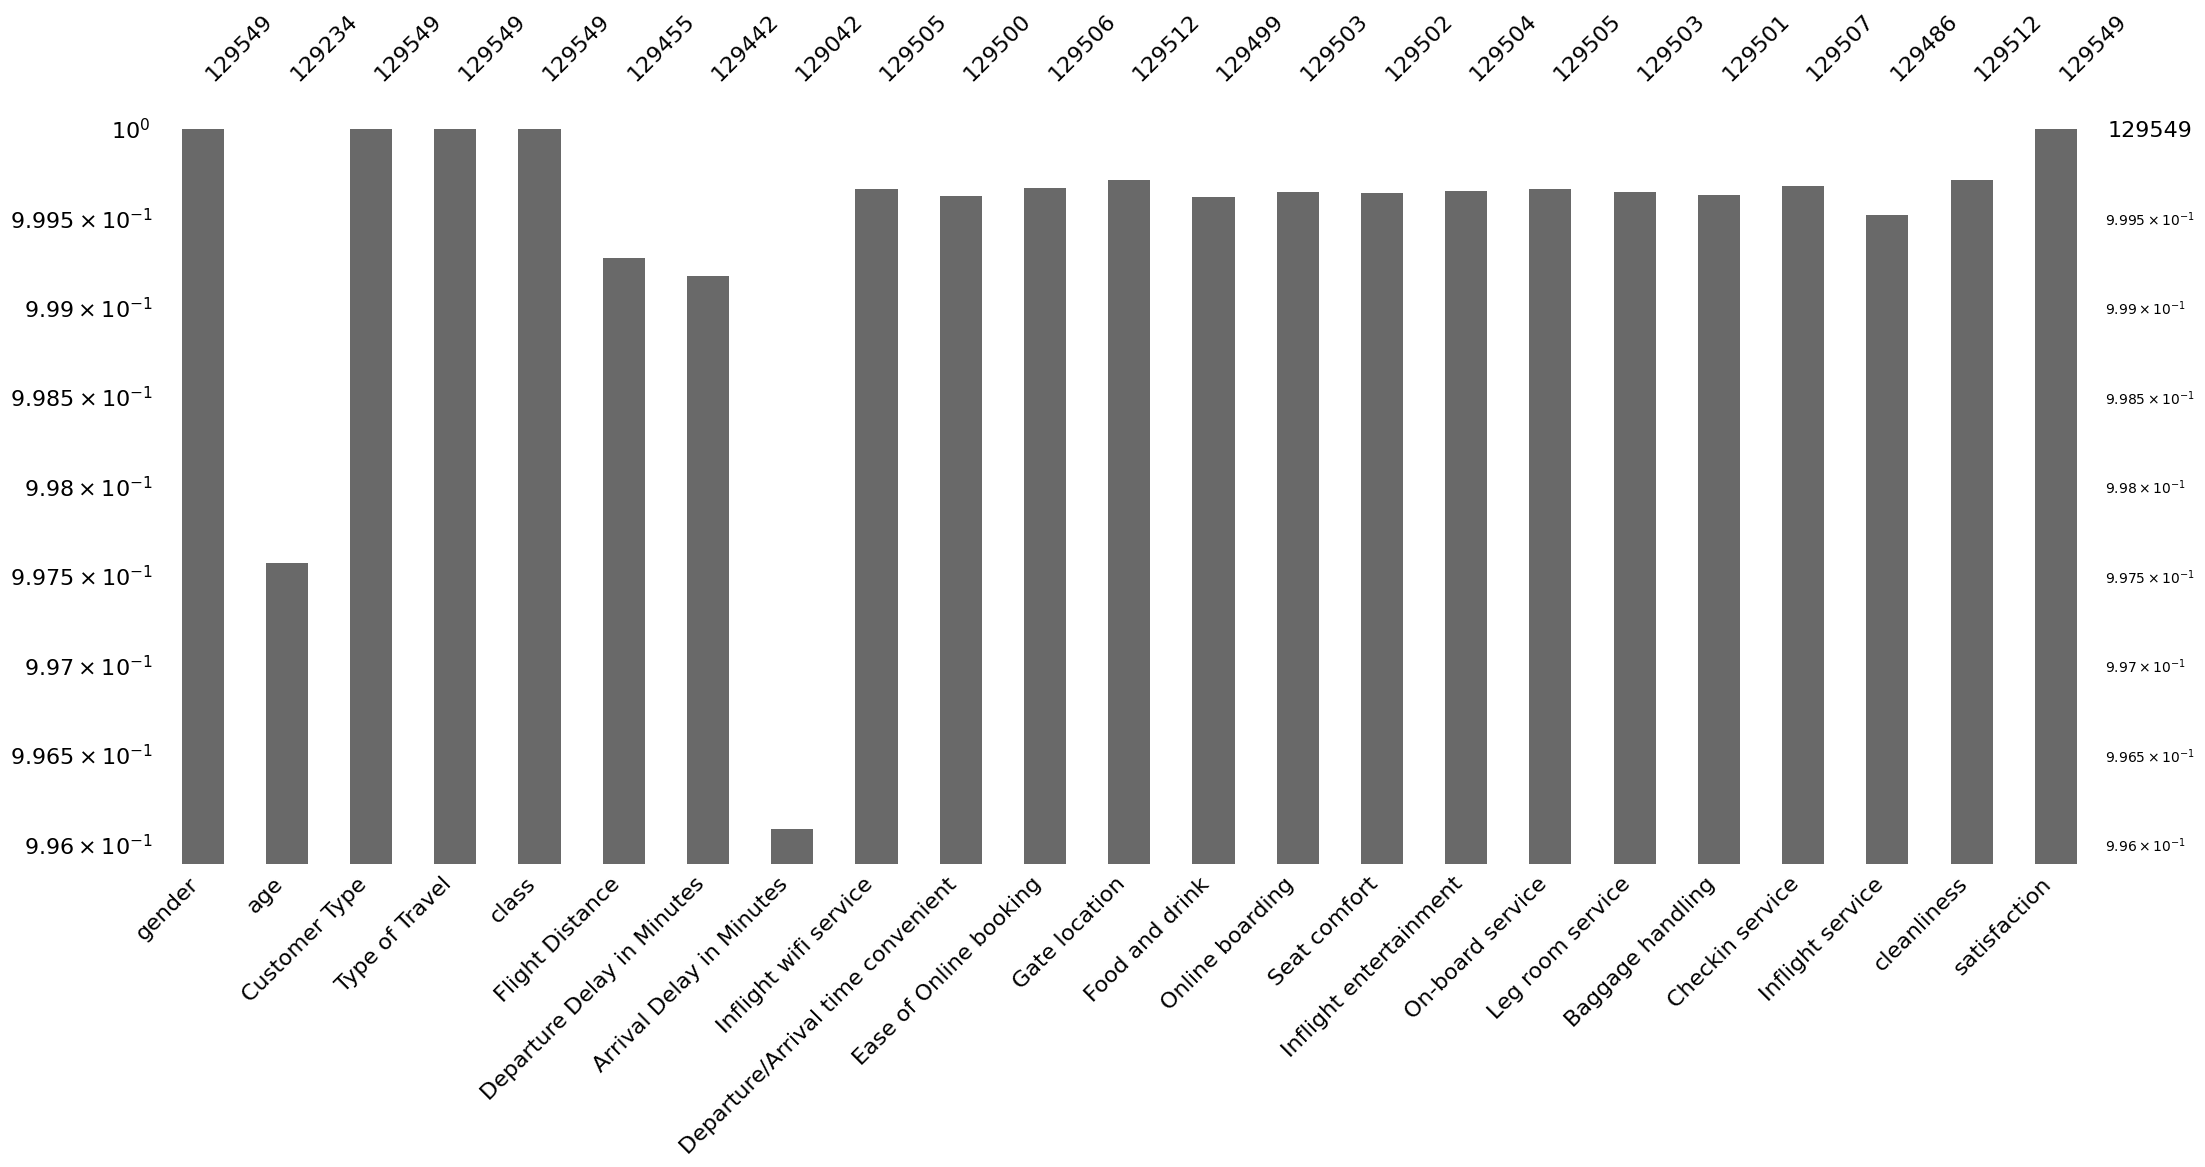

In [19]:
# Ваш код ниже
missingno.bar(df, log=True)
plt.show()

больше всего пропусков в колонке "Arrival Delay in Minutes"

Разобьем датасет на тренировочную и тестовую части. Тестовую часть отложим надолго -- до самого конца этого ноутбука.

In [12]:
df_train = df[df.satisfaction != '-']
df_train

gender   age      Customer Type   Type of Travel     class  \
0         Male  43.0     Loyal Customer  Business travel  Business   
1         Male  24.0  disloyal Customer  Business travel       Eco   
2       Female  61.0     Loyal Customer  Personal Travel       Eco   
3         Male  35.0  disloyal Customer  Business travel  Business   
4       Female  46.0     Loyal Customer  Business travel  Business   
...        ...   ...                ...              ...       ...   
129542  Female  28.0     Loyal Customer  Personal Travel       Eco   
129543    Male  66.0     Loyal Customer  Personal Travel       Eco   
129544  Female  59.0     Loyal Customer  Personal Travel       Eco   
129545    Male  61.0     Loyal Customer  Personal Travel       Eco   
129546    Male  44.0     Loyal Customer  Personal Travel       Eco   

        Flight Distance  Departure Delay in Minutes  Arrival Delay in Minutes  \
0                1963.0                         0.0                       0.0   
1                 453.0                        16.0                      30.0   
2                 821.0                         0.0                       0.0   
3                 212.0                         0.0                       0.0   
4                  67.0                         0.0                       0.0   
...                 ...                         ...                       ...   
129542            447.0                        23.0                      16.0   
129543            337.0                       199.0                     213.0   
129544            308.0                        32.0                      24.0   
129545            337.0                         0.0                       0.0   
129546            447.0                         0.0                       0.0   

        Inflight wifi service  Departure/Arrival time convenient  ...  \
0                         3.0                                3.0  ...   
1                         2.0                                2.0  ...   
2                         2.0                                5.0  ...   
3                         2.0                                2.0  ...   
4                         3.0                                3.0  ...   
...                       ...                                ...  ...   
129542                    1.0                                3.0  ...   
129543                    2.0                                4.0  ...   
129544                    3.0                                5.0  ...   
129545                    2.0                                4.0  ...   
129546                    2.0                                5.0  ...   

        Online boarding  Seat comfort  Inflight entertainment  \
0                   4.0           5.0                     5.0   
1                   2.0           5.0                     5.0   
2                   1.0           5.0                     5.0   
3                   2.0           2.0                     2.0   
4                   5.0           4.0                     4.0   
...                 ...           ...                     ...   
129542              1.0           3.0                     3.0   
129543              5.0           5.0                     5.0   
129544              5.0           5.0                     3.0   
129545              2.0           3.0                     3.0   
129546              2.0           5.0                     5.0   

        On-board service  Leg room service  Baggage handling  Checkin service  \
0                    5.0               5.0               5.0              4.0   
1                    2.0               4.0               4.0              2.0   
2                    5.0               2.0               5.0              5.0   
3                    4.0               5.0               5.0              5.0   
4                    4.0               4.0               4.0              5.0   
...                  ...               ...        

In [40]:
assert df_train.shape == (103_644, 23)

In [13]:
df_test = df[df.satisfaction == '-'].drop('satisfaction', axis=1)
df_test

gender   age   Customer Type   Type of Travel     class  \
5         Male  36.0  Loyal Customer  Business travel  Business   
7       Female  70.0  Loyal Customer  Personal Travel       Eco   
12        Male  66.0  Loyal Customer  Personal Travel       Eco   
19      Female  60.0  Loyal Customer  Business travel  Business   
24        Male  43.0  Loyal Customer  Personal Travel  Business   
...        ...   ...             ...              ...       ...   
129531    Male  38.0  Loyal Customer  Business travel       Eco   
129535    Male  16.0  Loyal Customer  Personal Travel       Eco   
129539  Female  43.0  Loyal Customer  Personal Travel       Eco   
129547    Male  47.0  Loyal Customer  Business travel  Eco Plus   
129548    Male  28.0  Loyal Customer  Personal Travel  Eco Plus   

        Flight Distance  Departure Delay in Minutes  Arrival Delay in Minutes  \
5                3655.0                        40.0                      71.0   
7                 108.0                        50.0                      41.0   
12                562.0                        88.0                      84.0   
19               3756.0                        36.0                      24.0   
24                802.0                         0.0                       0.0   
...                 ...                         ...                       ...   
129531            337.0                        92.0                      82.0   
129535            308.0                         2.0                       0.0   
129539            308.0                         0.0                       0.0   
129547            447.0                         0.0                       0.0   
129548            447.0                         2.0                       3.0   

        Inflight wifi service  Departure/Arrival time convenient  ...  \
5                         1.0                                1.0  ...   
7                         5.0                                4.0  ...   
12                        2.0                                5.0  ...   
19                        4.0                                4.0  ...   
24                        1.0                                2.0  ...   
...                       ...                                ...  ...   
129531                    4.0                                3.0  ...   
129535                    3.0                                4.0  ...   
129539                    2.0                                4.0  ...   
129547                    3.0                                4.0  ...   
129548                    4.0                                4.0  ...   

        Food and drink  Online boarding  Seat comfort  Inflight entertainment  \
5                  1.0              3.0           3.0                     3.0   
7                  4.0              4.0           4.0                     3.0   
12                 5.0              2.0           5.0                     5.0   
19                 2.0              4.0           5.0                     4.0   
24                 2.0              3.0           3.0                     2.0   
...                ...              ...           ...                     ...   
129531             4.0              5.0           4.0                     4.0   
129535             1.0              3.0           5.0                     1.0   
129539             3.0              5.0           5.0                     4.0   
129547             4.0              3.0           4.0                     4.0   
129548             4.0              4.0           1.0                     4.0   

        On-board service  Leg room service  Baggage handling  Checkin service  \
5                    3.0               3.0               1.0              4.0   
7                    3.0               0.0               3.0              5.0   
12                   3.0               5.0               2.0              5.0   
19                   4.0               4.0              

In [42]:
assert df_test.shape == (25_905, 22)

Разбиваем данные на трейн и валидацию. Не меняйте сид

In [14]:
X_train, X_val, y_train, y_val = train_test_split(df_train.drop('satisfaction', axis=1), df_train.satisfaction, test_size=0.3, random_state=42)

In [44]:
assert X_train.shape == (72_550, 22)
assert X_val.shape == (31_094, 22)

### **Задание 4. (0.15 балла)**

Заполните пропуски в данных наиболее часто встречающимся значением.
Помните про правильность заполнения.

**Примечание:** Мы также могли восстановать пропуски `KNNImputer`'ом или `IterativeImputer`'ом. Как правило, такое заполнение точнее и лучше сохраняет структуру распределений. Но для признаков в нашей задаче Imputer'ы, реализованные библиотечно не подошли бы. Они возвращали бы вещественные значения, а в нашей задаче все признаки целые.

In [15]:
# Ваш код ниже
cols_nans = X_train.columns[X_train.isna().sum() > 0]
for col in cols_nans:
    X_train[col] = X_train[col].fillna(X_train[col].mode()[0])
    X_val[col] = X_val[col].fillna(X_train[col].mode()[0])
    df_test[col] = df_test[col].fillna(X_train[col].mode()[0])

In [21]:
X_train.isna().sum().sum()

0

### **Задание 5. (0.1 балла)**

- Выведите основные статистики по числовым и категориальным столбцам таблицы
- Сделайте **текстовый** вывод о распределениях значений признаков

In [159]:
# Ваш код ниже
display(X_train.describe().round(2))
display(X_train.describe(include='object'))
print('X_val:')
display(X_val.describe().round(2))
display(X_val.describe(include='object'))

age  Flight Distance  Departure Delay in Minutes  \
count  72550.00         72550.00                    72550.00   
mean      40.10          1329.02                       15.86   
std       20.66          4764.37                       70.86   
min        0.00             0.00                        0.00   
25%       27.00           413.00                        0.00   
50%       40.00           844.00                        0.00   
75%       51.00          1744.00                       12.00   
max      544.00        379620.00                     9282.00   

       Arrival Delay in Minutes  Inflight wifi service  \
count                  72550.00               72550.00   
mean                      16.65                   2.73   
std                       97.99                   1.36   
min                        0.00                   0.00   
25%                        0.00                   2.00   
50%                        0.00                   3.00   
75%                       13.00                   4.00   
max                    11760.00                  45.00   

       Departure/Arrival time convenient  Ease of Online booking  \
count                           72550.00                72550.00   
mean                                3.07                    2.76   
std                                 1.55                    1.41   
min                                 0.00                    0.00   
25%                                 2.00                    2.00   
50%                                 3.00                    3.00   
75%                                 4.00                    4.00   
max                                45.00                   28.00   

       Gate location  Food and drink  Online boarding  Seat comfort  \
count       72550.00        72550.00         72550.00      72550.00   
mean            2.98            3.21             3.26          3.45   
std             1.32            1.35             1.37          1.35   
min             0.00            0.00             0.00          0.00   
25%             2.00            2.00             2.00          2.00   
50%             3.00            3.00             3.00          4.00   
75%             4.00            4.00             4.00          5.00   
max            36.00           36.00            32.00         45.00   

       Inflight entertainment  On-board service  Leg room service  \
count                72550.00          72550.00          72550.00   
mean                     3.36              3.38              3.35   
std                      1.36              1.33              1.36   
min                      0.00              0.00              0.00   
25%                      2.00              2.00              2.00   
50%                      4.00              4.00              4.00   
75%                      4.00              4.00              4.00   
max                     40.00             45.00             36.00   

       Baggage handling  Checkin service  Inflight service  cleanliness  
count          72550.00         72550.00          72550.00     72550.00  
mean               3.63             3.31              3.64         3.29  
std                1.23             1.29              1.22         1.34  
min                0.00             0.00              0.00         0.00  
25%                3.00             3.00              3.00         2.00  
50%                4.00             3.00              4.00         3.00  
75%                5.00             4.00              5.00         4.00  
max               40.00            45.00             36.00        45.00

gender   Customer Type   Type of Travel     class
count    72550           72550            72550     72550
unique       2               3                3         4
top     Female  Loyal Customer  Business travel  Business
freq     36816           59354            49984     34727

X_val:


age  Flight Distance  Departure Delay in Minutes  \
count  31094.00         31094.00                    31094.00   
mean      39.96          1316.47                       15.67   
std       19.55          4379.00                       80.66   
min        0.00             0.00                        0.00   
25%       27.00           417.00                        0.00   
50%       40.00           845.00                        0.00   
75%       51.00          1744.00                       12.00   
max      612.00        255522.00                    11011.00   

       Arrival Delay in Minutes  Inflight wifi service  \
count                  31094.00               31094.00   
mean                      16.87                   2.73   
std                      131.10                   1.35   
min                        0.00                   0.00   
25%                        0.00                   2.00   
50%                        0.00                   3.00   
75%                       13.00                   4.00   
max                    14006.00                  40.00   

       Departure/Arrival time convenient  Ease of Online booking  \
count                           31094.00                31094.00   
mean                                3.06                    2.76   
std                                 1.56                    1.44   
min                                 0.00                    0.00   
25%                                 2.00                    2.00   
50%                                 3.00                    3.00   
75%                                 4.00                    4.00   
max                                35.00                   45.00   

       Gate location  Food and drink  Online boarding  Seat comfort  \
count       31094.00        31094.00         31094.00      31094.00   
mean            2.98            3.20             3.25          3.44   
std             1.29            1.36             1.41          1.36   
min             1.00            0.00             0.00          0.00   
25%             2.00            2.00             2.00          2.00   
50%             3.00            3.00             3.00          4.00   
75%             4.00            4.00             4.00          5.00   
max            32.00           45.00            40.00         36.00   

       Inflight entertainment  On-board service  Leg room service  \
count                31094.00          31094.00          31094.00   
mean                     3.36              3.39              3.37   
std                      1.36              1.34              1.38   
min                      0.00              0.00              0.00   
25%                      2.00              2.00              2.00   
50%                      4.00              4.00              4.00   
75%                      4.00              4.00              4.00   
max                     36.00             40.00             40.00   

       Baggage handling  Checkin service  Inflight service  cleanliness  
count          31094.00         31094.00          31094.00     31094.00  
mean               3.65             3.31              3.66         3.29  
std                1.22             1.32              1.20         1.35  
min                1.00             0.00              1.00         0.00  
25%                3.00             3.00              3.00         2.00  
50%                4.00             3.00              4.00         3.00  
75%                5.00             4.00              5.00         4.00  
max               40.00            45.00             35.00        40.00

gender   Customer Type   Type of Travel     class
count    31094           31094            31094     31094
unique       2               3                3         4
top     Female  Loyal Customer  Business travel  Business
freq     15774           25301            21439     14760

По числовым в `train`:
- медиана в `age` - 40 лет, есть некорректные данные по типу (0 лет, 544 года)
- есть аномально большие значения в `Flight Distance`, `Departure Delay in Minutes`, `Arrival Delay in Minutes`
- в оценках, которая подразумевается 5-ти балльной, есть странные значения (45,36, 32 и т.д.)

Категориальные:
- женщины преобладают над мужчинами
- больше всего лояльных клиентов
- больше всего клиентов, которые летают по бизнес-поездкам
- больше всего клиентов, которые летают бизнес-классом

В `val` все, в целом, так же по распределению


### **Задание 6 (0.25 балла)**

- Удалите строки c выбросами в числовых столбцах (для трейна и валидации; тест оставьте без изменений).

**Примечание:** Выбросами считайте значения признака, строго превышающие 0.996-квантиль.

По определению, квантиль — значение, которое заданная случайная величина не превышает с фиксированной вероятностью. То есть, если мы смотрим на квантиль 0.996-квантиль, то значения после этого квантиля встречаются в 0.004% случаев. В среднем для всех признаков эти значения начинаются ~в этом квантиле.


--------
здесь явно написано, что тест не трогать, а в прошлом написано не было, поэтому я там пропуски заполнила (извините, если не надо было)

In [16]:
# Ваш код ниже
for col in num_cols:
    q = X_train[col].quantile(0.996)

    mask_train = X_train[col] <= q
    X_train = X_train[mask_train]
    y_train = y_train.loc[X_train.index]

    mask_val = X_val[col] <= q
    X_val = X_val[mask_val]
    y_val = y_val.loc[X_val.index]

In [47]:
assert df_test.shape == (25_905, 22)

## **1. 2. EDA (1 балл)**

Создадим переменные с перечислениями столбцов разного типа

In [17]:
continuous_cols = ['age', 'Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']
ordinal_cols = list(set(df.select_dtypes(include='number').columns) - set(continuous_cols))
categorical_cols = list(df.select_dtypes(include='object').columns)[:-1]

In [27]:
assert len(continuous_cols + ordinal_cols + categorical_cols) == 22

### **Задание 7. (0.3 балла)**

- Напишите процедуры для отрисовки графиков;
 * Для признаков, которые мы выделили как порядковые и для категориальных, отображайте только `countplot`
  * Для тех, что считаем континуальными, -- гистограмму распределения признака и ящик с усами (inline)

- Вызовите все 3 написанные процедуры для соответствующих колонок `X_train`. Отдельно визуализируйте распределение таргета в трейне. Всё должно красиво работать! :)

**Примечание 1:**

Помните про хороший тон визуализации — все графики и их оси обязательно должны быть подписаны, легенда на графике также необходима! За неё также могут быть сняты баллы.

**Примечание 2:**

Обязательно выделяйте таргет разными цветами. Мы же хотим в конечном итоге понять, чем удовлетворенные клиенты отличаются от недовольных.

In [164]:
def plot_ordinal(cols, df, y):
    """Draws countplots for all columns in 'cols' with informative title"""
    num_cols = 3
    num_rows = len(cols) // num_cols + bool(len(cols) % num_cols)
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 30))
    axes = axes.flatten()
    palette = {"neutral or dissatisfied": sns.color_palette("tab10")[1],
               "satisfied": sns.color_palette("tab10")[0]}
    for i, col in enumerate(cols):
        sns.countplot(data=df, x=col, hue=y, palette=palette, ax=axes[i])
        axes[i].set_title(f'Distribution of {col}')
        axes[i].legend(title='target')

    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])
    plt.tight_layout()

In [165]:
def plot_continuous(cols, df, y):
    """Draws kdeplots and boxplots in one row
    for all columns in 'cols' with informative title
    """
    num_cols = 2
    num_rows = len(cols)
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))
    axes = axes.flatten()
    for i, col in enumerate(cols):
        sns.histplot(data=df, x=col, kde=True, hue=y, ax=axes[2*i])
        axes[2*i].set_title(f"distribution of {col}")
        sns.boxplot(data=df, x=y, y=col, ax=axes[2*i+1])
        axes[2*i+1].set_title(f"boxplot of {col}")
    plt.tight_layout()

In [166]:
def plot_categorical(cols, df, y):
    """Draws countplots for all columns in 'cols' with informative title"""
    num_cols = 3
    num_rows = len(cols) // num_cols + bool(len(cols) % num_cols)
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 8))
    axes = axes.flatten()
    for i, col in enumerate(cols):
        sns.countplot(data=df, x=col, hue=y, ax=axes[i])
        axes[i].set_title(f'Distribution of {col}')
        axes[i].legend(title='target')

    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])
    plt.tight_layout()

Отрисовка.

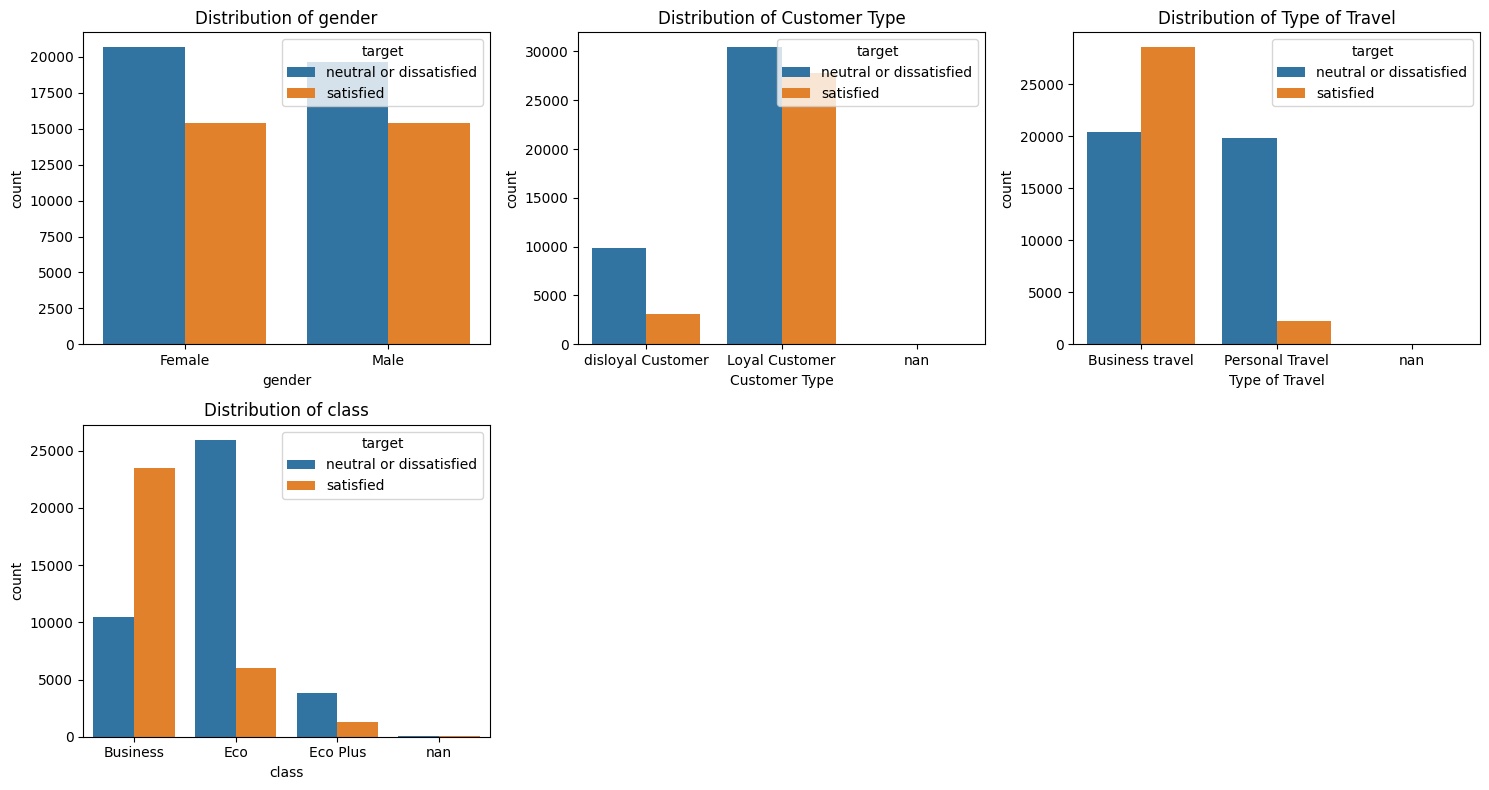

In [167]:
plot_categorical(categorical_cols, X_train, y_train)

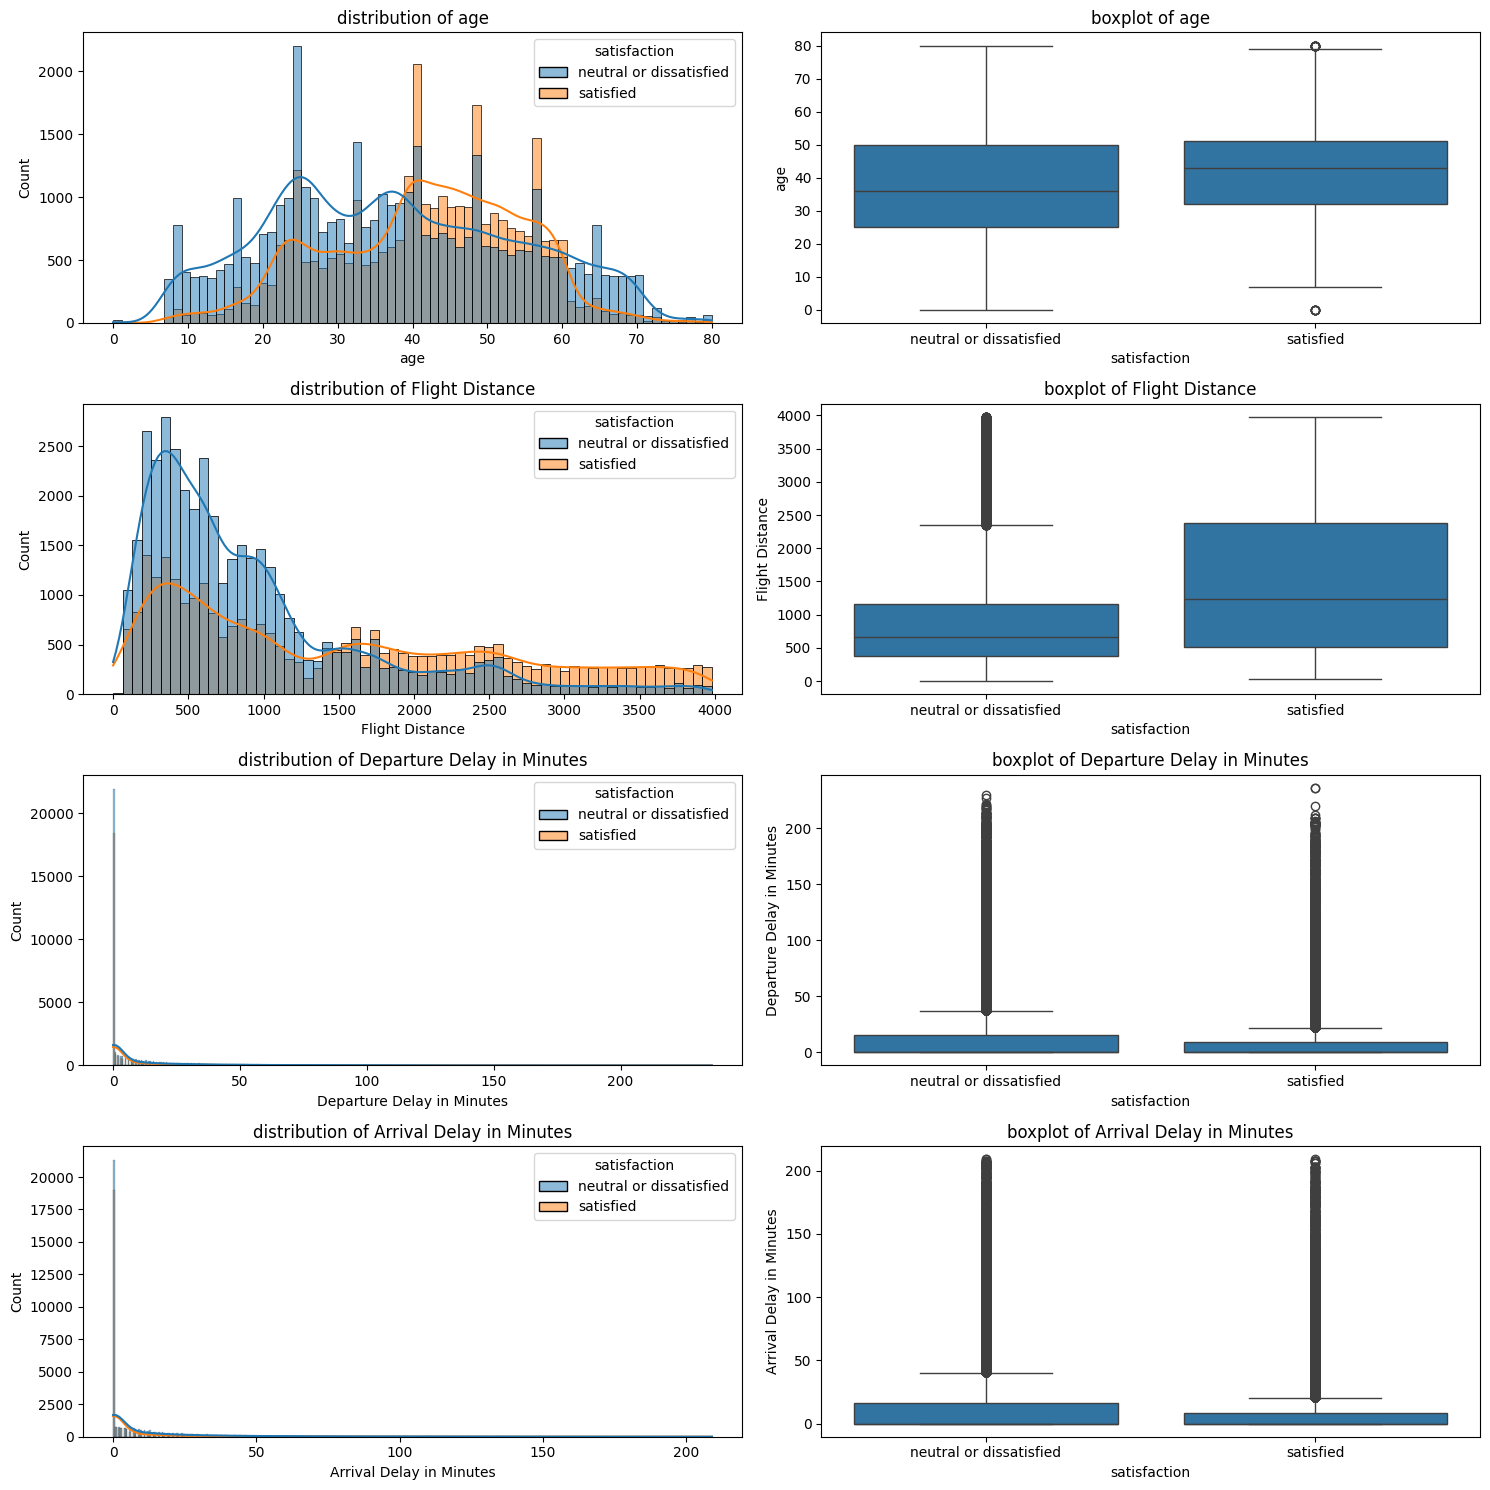

In [168]:
plot_continuous(continuous_cols, X_train, y_train)

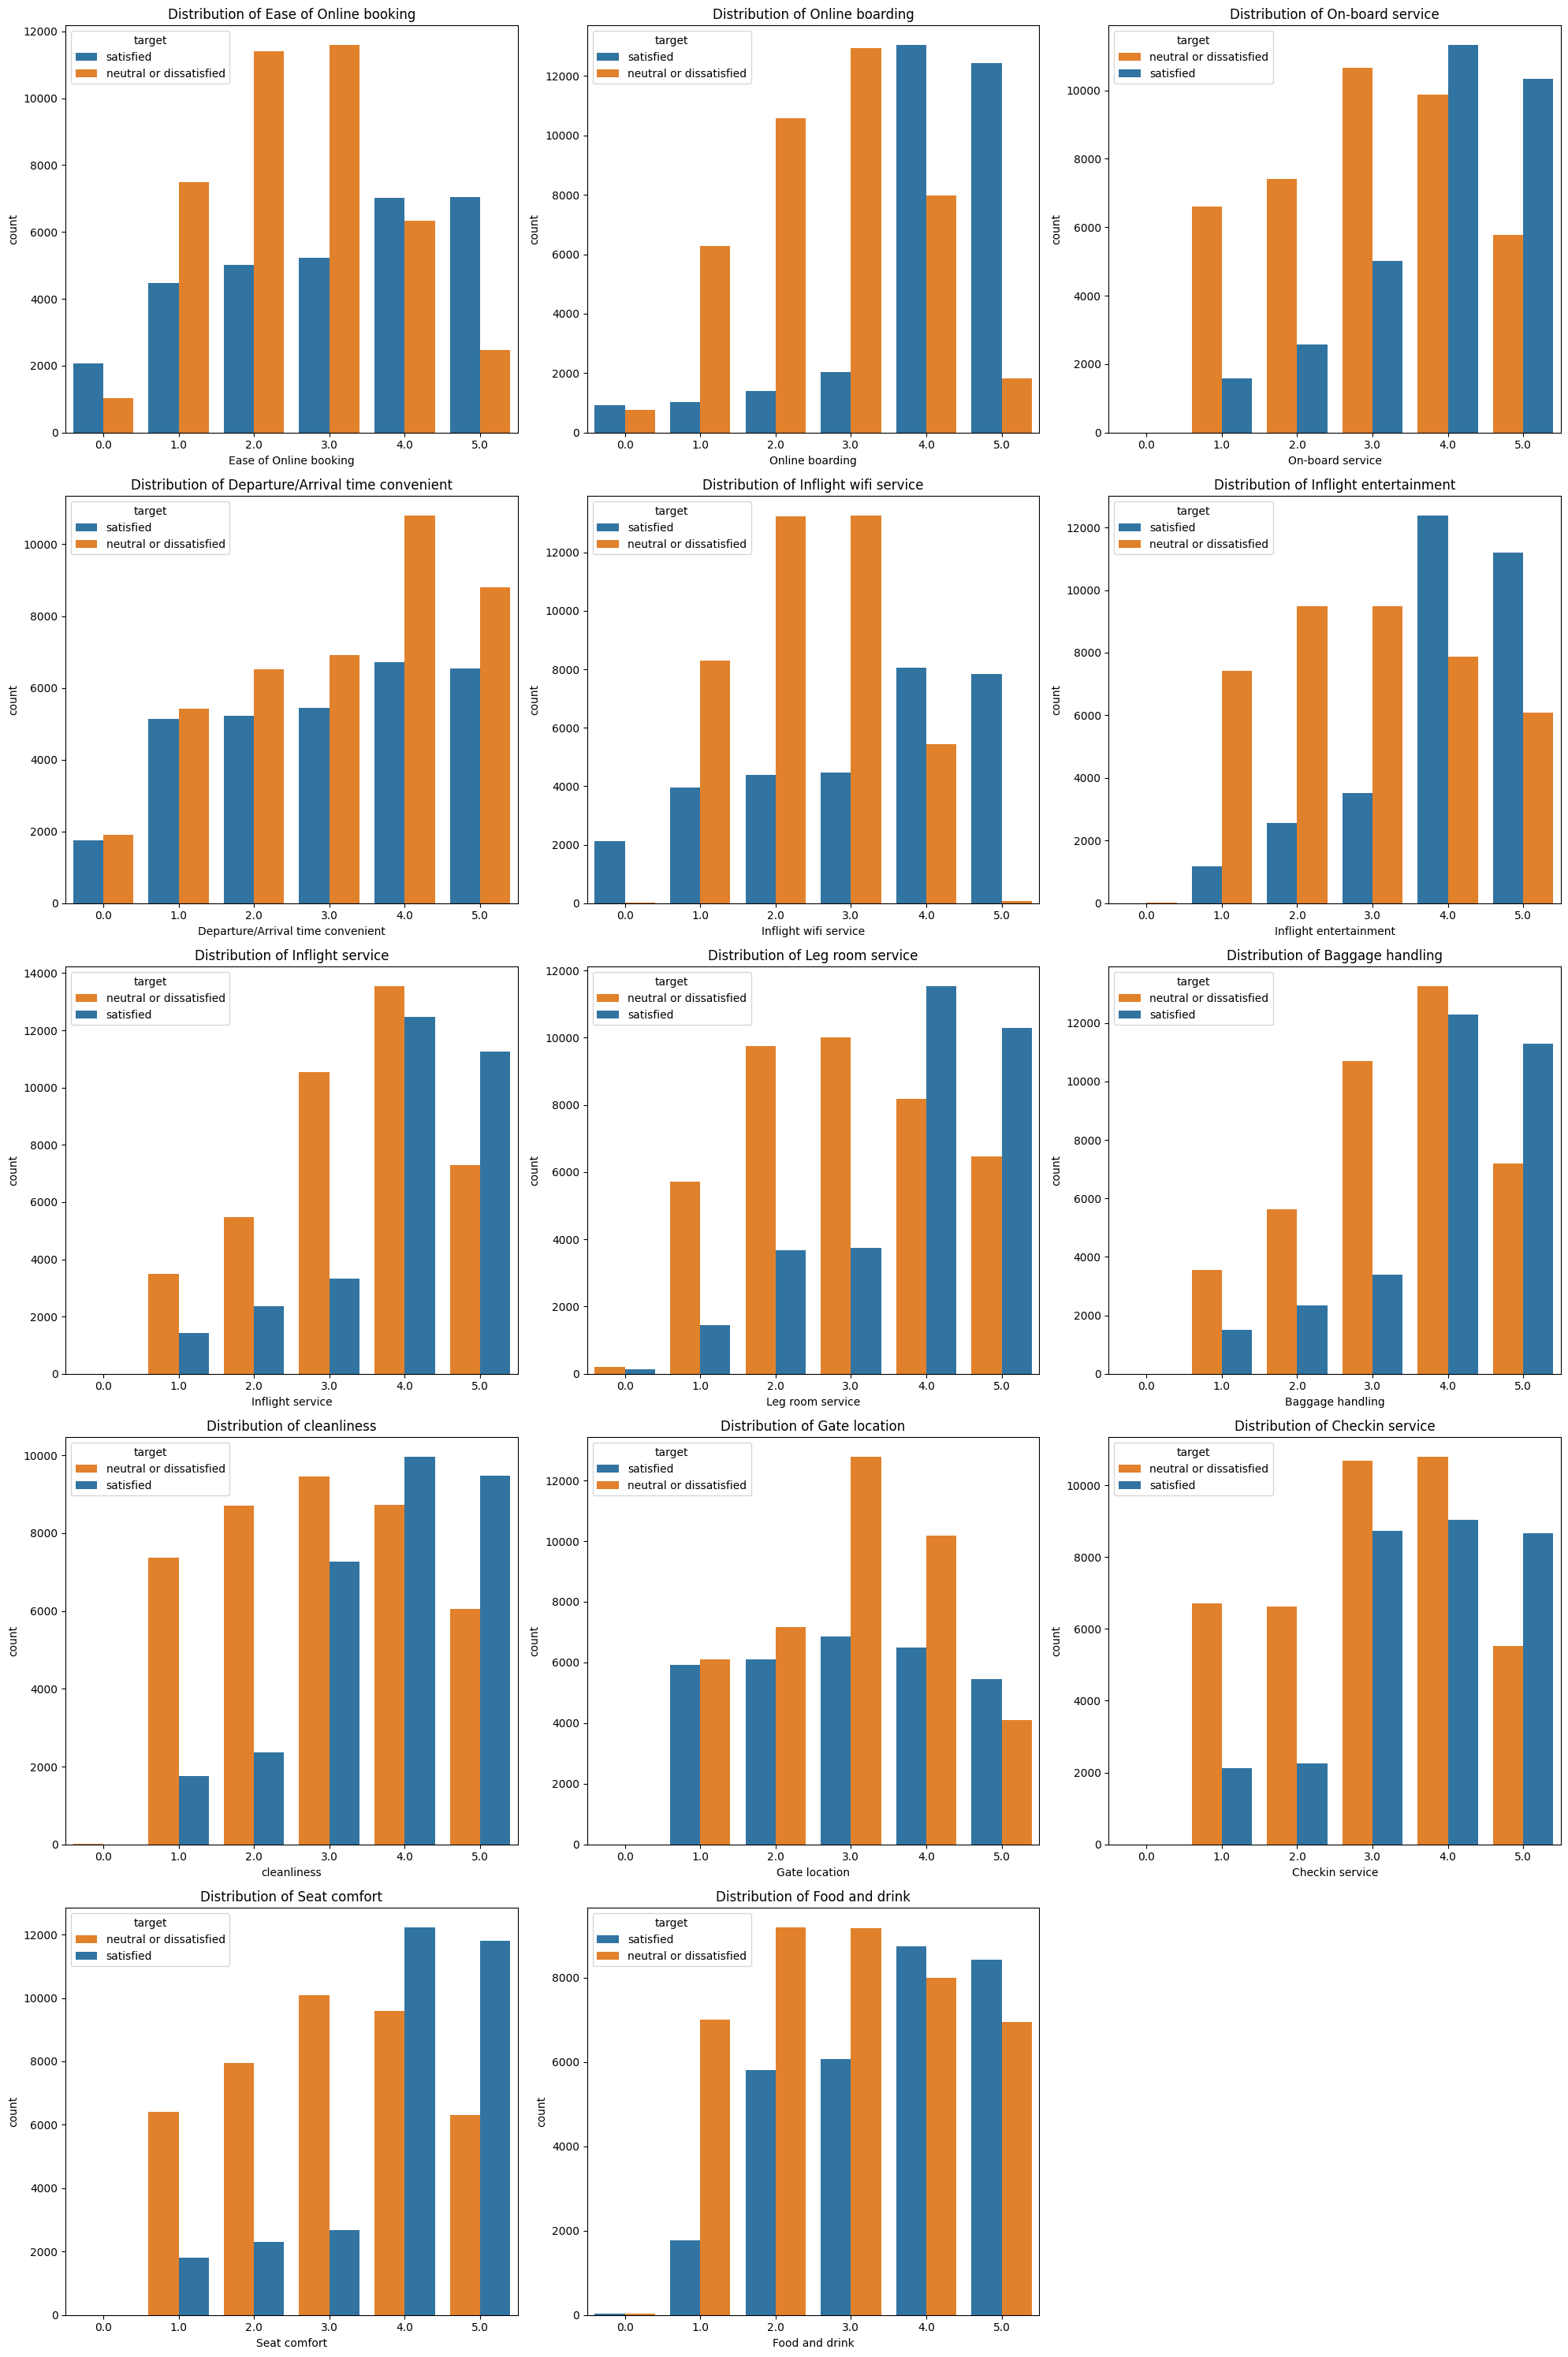

In [169]:
plot_ordinal(ordinal_cols, X_train, y_train)

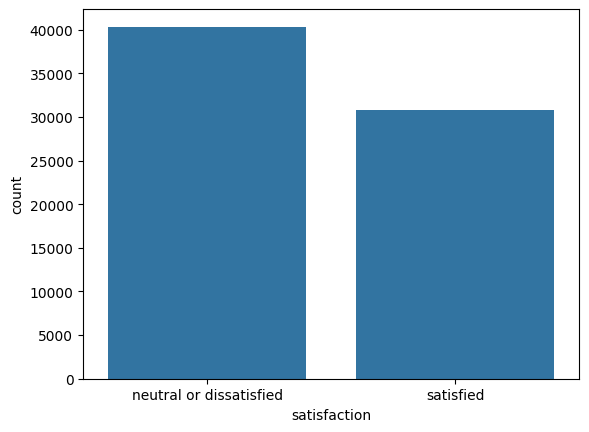

In [170]:
sns.countplot(data=None, x=y_train)
plt.show()

### **Задание 8 (0.2 балла)**

Сделайте выводы по построенным графикам.

Не забудьте упомянуть:
* какие признаки распределены неравномерно
* сбалансированы ли классы
* какие распределения имеют континуальные признаки

* Все, кроме распредления довольных и недовольных у мужчин и женщин распредлено неравномерно.
* Классы несбалансированы (довольных примерно на 1к меньше чем недовольных)
* Континуальные признаки: довольные пассажиры старше чем те, кто недовольны. Довольные пассажиры летают намного чаще на длиные дистанции, а недовольные - на короткие. Задержка прибытия и отпралвения имеют очень тяжелые правые хвосты.




### **Бонус (0.1 балла)**
По графикам (каким, решите сами) оцените, похожи ли оказались распределения признаков при разбиении на трейн, валидацию и тест.

In [171]:
print("train unique values:", X_train["Customer Type"].unique())
print("validation unique values:", X_val["Customer Type"].unique())
print("test unique values:", df_test["Customer Type"].unique())

train unique values: ['disloyal Customer' 'Loyal Customer' 'nan']
validation unique values: ['Loyal Customer' 'disloyal Customer' 'nan']
test unique values: ['Loyal Customer' 'disloyal Customer' 'nan']


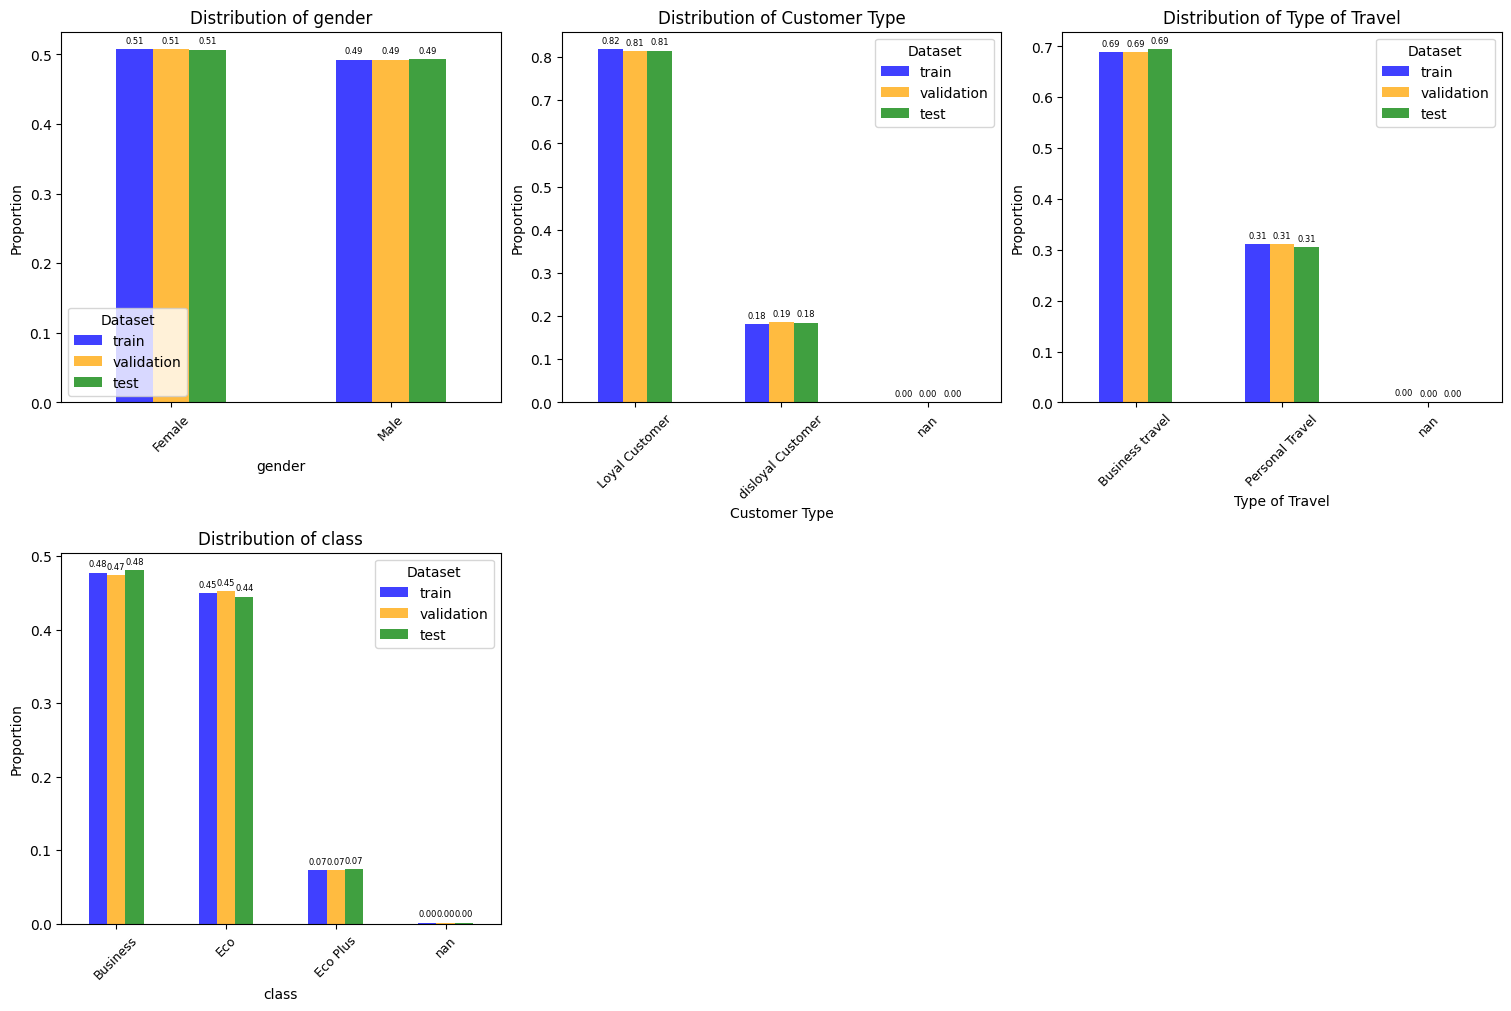

In [178]:
def compare_bar_distributions(cols, train, val, test):
    """
    Рисует bar-графики для сравнения распределений в категориальных колонках между train, val и test.
    """
    num_cols = 3
    num_rows = len(cols) // num_cols + (len(cols) % num_cols > 0)

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows), constrained_layout=True)
    axes = axes.flatten()

    for i, col in enumerate(cols):
        train_counts = train[col].value_counts(normalize=True).rename("train")
        val_counts = val[col].value_counts(normalize=True).rename("validation")
        test_counts = test[col].value_counts(normalize=True).rename("test")
        combined = pd.concat([train_counts, val_counts, test_counts], axis=1).fillna(0)
        combined.plot(kind="bar", ax=axes[i], alpha=0.75, color=["blue", "orange", "green"])
        axes[i].set_title(f"Distribution of {col}", fontsize=12)
        axes[i].set_xlabel(col, fontsize=10)
        axes[i].tick_params(axis="x", labelrotation=45, labelsize=9)
        axes[i].set_ylabel("Proportion", fontsize=10)
        axes[i].legend(title="Dataset")

        for container in axes[i].containers:
            axes[i].bar_label(container, fmt="%.2f", label_type="edge", fontsize=6, padding=3)

    for j in range(len(cols), len(axes)):
        fig.delaxes(axes[j])

    plt.show()

compare_bar_distributions(categorical_cols, X_train, X_val, df_test)

Видим, что по данным категориальным колонкам данные почти идеально сбалансированы

### **Задание 9 (0.25 балла)**

- Замените признаки "Departure Delay in Minutes" и "Arrival Delay in Minutes" на их логарифмы.
- Заново постройте графики континуальных признаков и сделайте вывод по преобразованию

Некоторые признаки полезно рассматривать в логарифмической шкале. Зачем? Она помогает анализировать большие диапазоны изменений (посмотрите на график логарифма).


In [18]:
# Ваш код ниже
for col in ['Departure Delay in Minutes', 'Arrival Delay in Minutes']:
    X_train[col] = np.log1p(X_train[col])

Построение.

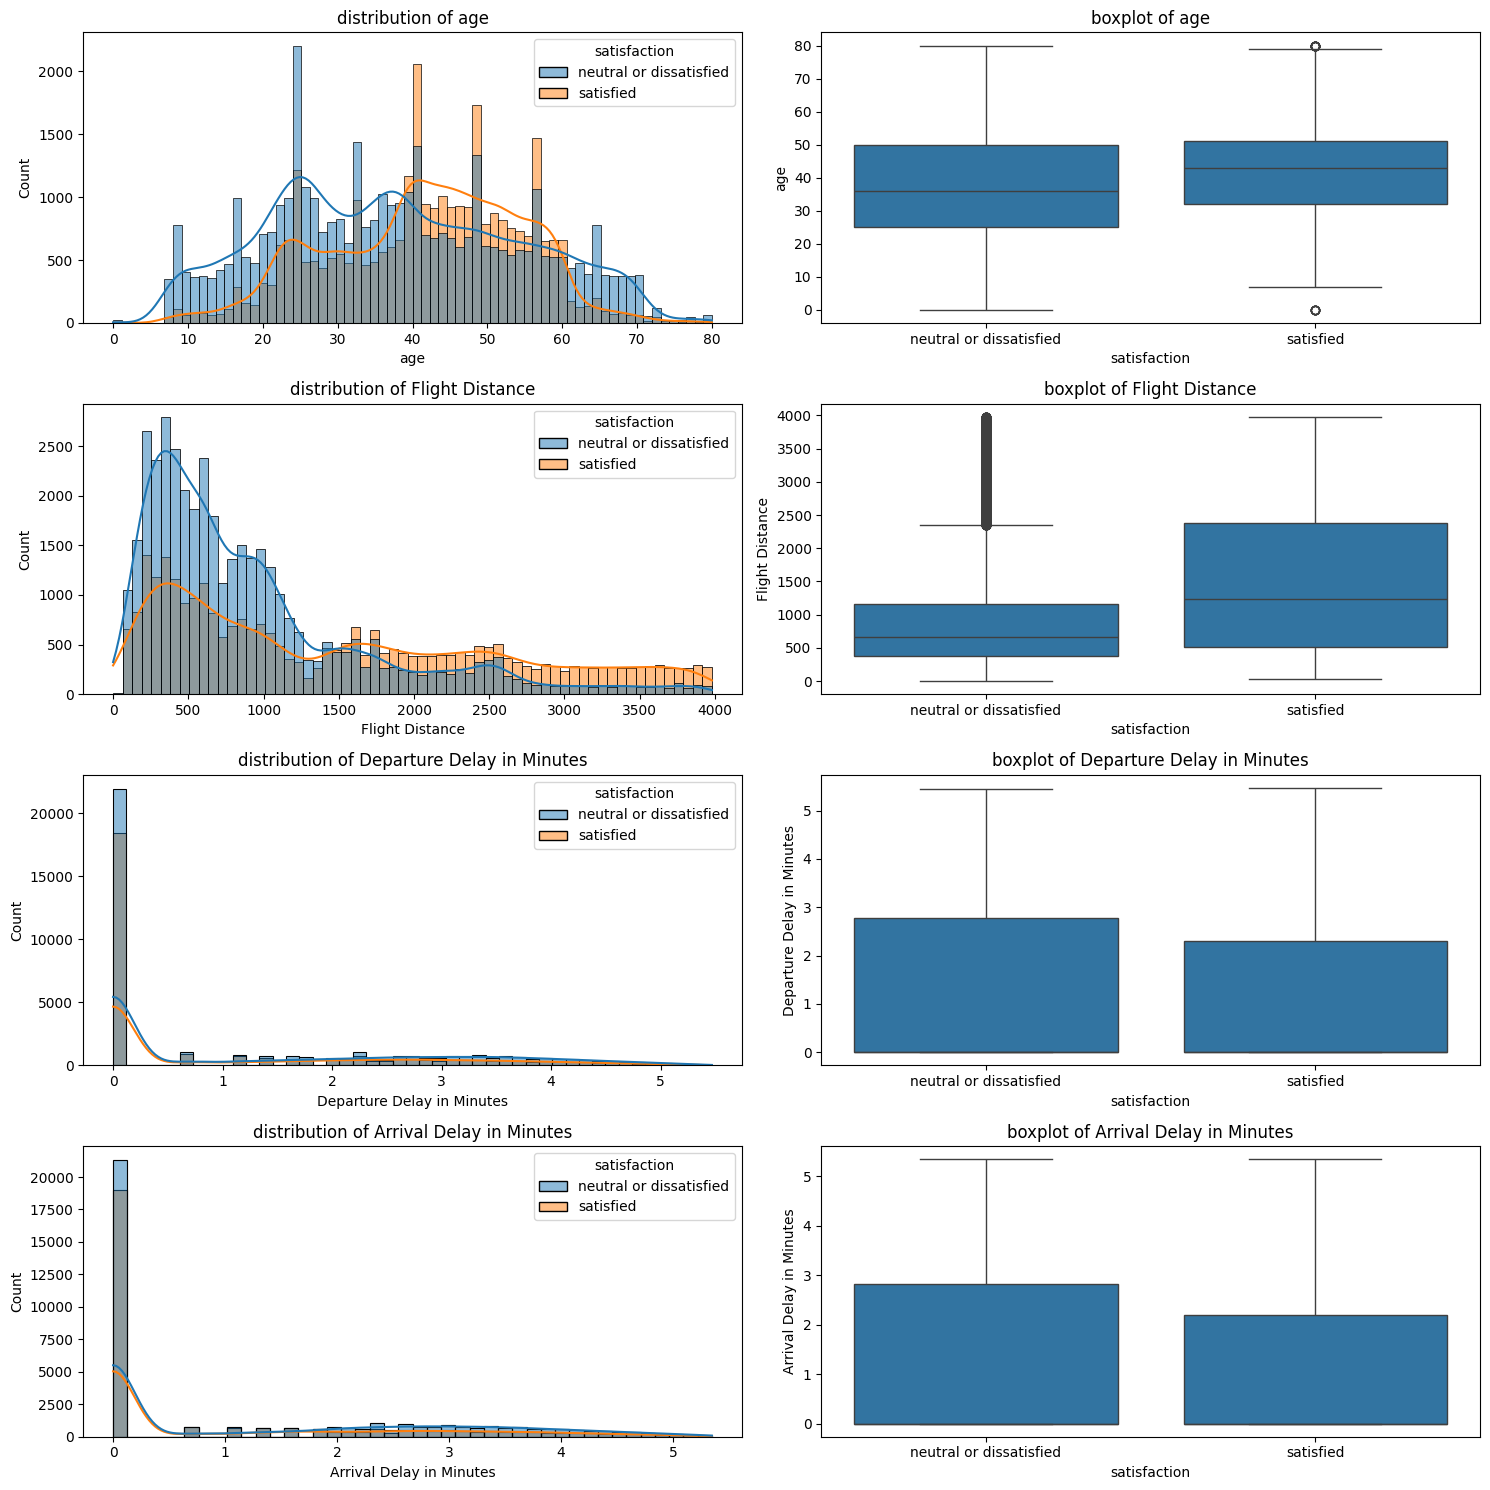

In [180]:
plot_continuous(continuous_cols, X_train, y_train)

итог: графики стали лучше визулизироваться. Мы сохранили порядок, так логарифм монотонный и при это убрали тяжелые правые хвосты, так как логарифм медленно растет

### **Задание 10 (0.25 балла)**

Выше вы рассмотрели `boxplot` и графики распределений. Но иногда полезным оказывается `scatterplot, (pairplot)` в seabron. Проверьте, что покажет этот график в нашей задаче.

- Отобразите попарное распределение континуальных (по договоренности) признаков. Покрасьте точки на pairplot'е в соответствии с их классом.

**Примечание:**
Наблюдений много, так что отрисовка графика вполне может занять несколько минут

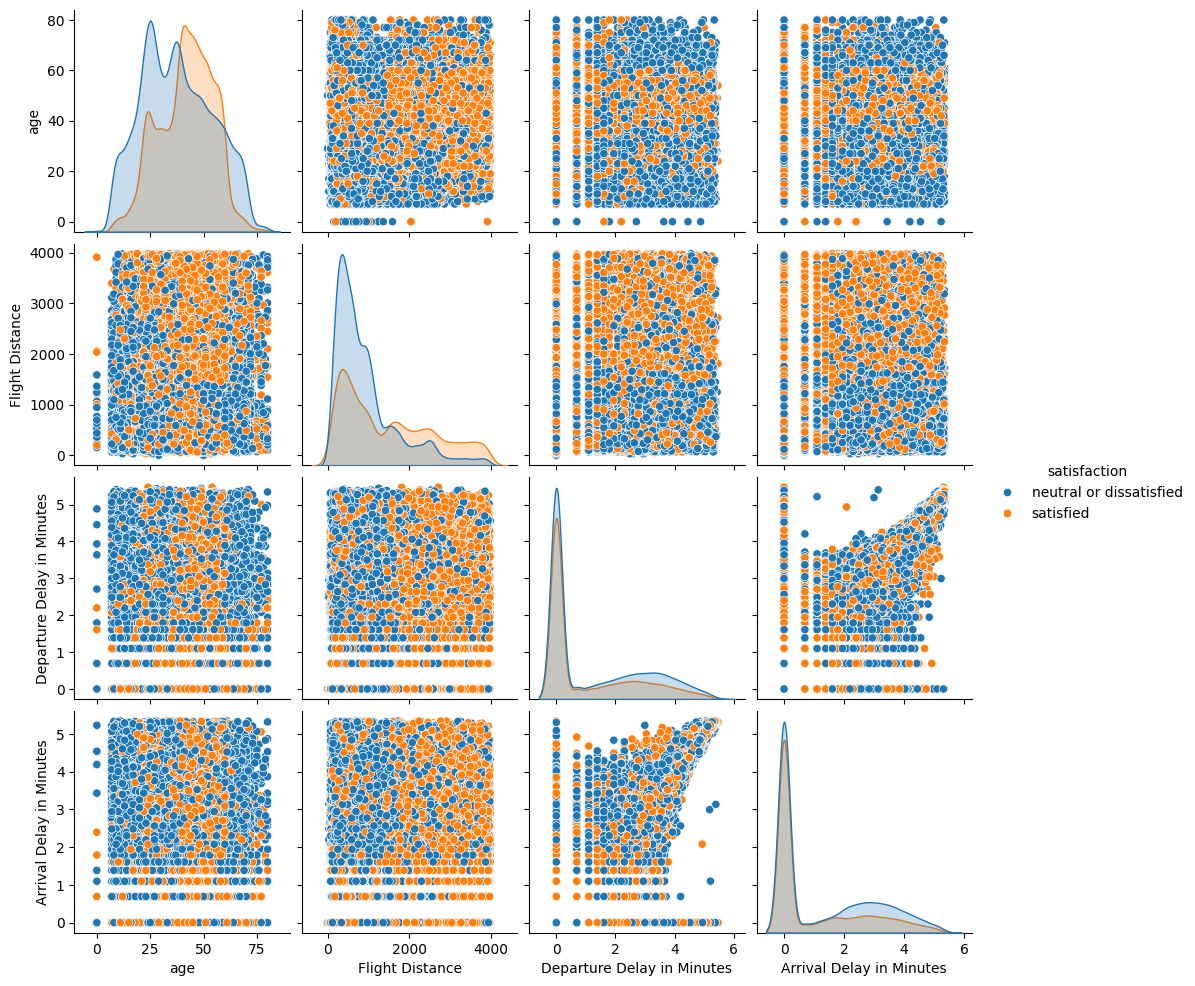

In [181]:
data = X_train[continuous_cols].copy()
data['satisfaction'] = y_train
sns.pairplot(data=data, hue="satisfaction")
plt.show()

ничего нового сказать из графиков нельзя

# **Часть 2. Decision Tree (3 балла)**

### **Задание 11 (0.4 балла)**

Предобработайте данные для алгоритма.
- Закодируйте таргет таким образом, чтоб 'satisfied' перешел в 1, а остальные значения в 0;
- Закодируйте категориальные признаки методом OHE;

In [19]:
y_train = y_train.map({'satisfied': 1, 'neutral or dissatisfied': 0})
y_val = y_val.map({'satisfied': 1, 'neutral or dissatisfied': 0})

In [20]:
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first')
X_train_enc = ohe.fit_transform(X_train[categorical_cols])
X_val_enc = ohe.transform(X_val[categorical_cols])
cols = ohe.get_feature_names_out(categorical_cols)

X_train_ohe = pd.DataFrame(X_train_enc, columns=cols, index=X_train.index)
X_val_ohe = pd.DataFrame(X_val_enc, columns=cols, index=X_val.index)

X_train_ohe = pd.concat([X_train.drop(columns=categorical_cols), X_train_ohe], axis=1)
X_val_ohe = pd.concat([ X_val.drop(columns=categorical_cols), X_val_ohe], axis=1)

In [30]:
X_train_ohe

age  Flight Distance  Departure Delay in Minutes  \
32590  29.0            785.0                         0.0   
66281  45.0           3269.0                         0.0   
90429   8.0           1431.0                         0.0   
68777  48.0            602.0                         0.0   
54906  25.0            651.0                         0.0   
...     ...              ...                         ...   
7838   25.0            337.0                         0.0   
68526  77.0           1448.0                         0.0   
96003  31.0            304.0                        21.0   
1103   45.0            661.0                         0.0   
19728  55.0           1359.0                         0.0   

       Arrival Delay in Minutes  Inflight wifi service  \
32590                       0.0                    2.0   
66281                       0.0                    0.0   
90429                       0.0                    3.0   
68777                       0.0                    4.0   
54906                       0.0                    5.0   
...                         ...                    ...   
7838                        0.0                    1.0   
68526                       0.0                    2.0   
96003                      12.0                    4.0   
1103                        0.0                    4.0   
19728                       0.0                    3.0   

       Departure/Arrival time convenient  Ease of Online booking  \
32590                                2.0                     2.0   
66281                                0.0                     0.0   
90429                                1.0                     3.0   
68777                                5.0                     4.0   
54906                                0.0                     5.0   
...                                  ...                     ...   
7838                                 4.0                     1.0   
68526                                5.0                     5.0   
96003                                4.0                     4.0   
1103                                 1.0                     4.0   
19728                                3.0                     3.0   

       Gate location  Food and drink  Online boarding  ...  Inflight service  \
32590            4.0             4.0              2.0  ...               5.0   
66281            3.0             2.0              2.0  ...               3.0   
90429            2.0             5.0              3.0  ...               1.0   
68777            3.0             2.0              5.0  ...               4.0   
54906            2.0             2.0              5.0  ...               1.0   
...              ...             ...              ...  ...               ...   
7838             4.0             4.0              1.0  ...               4.0   
68526            5.0             2.0              2.0  ...               3.0   
96003            1.0             1.0              4.0  ...               5.0   
1103             4.0             2.0              4.0  ...               4.0   
19728            3.0             3.0              3.0  ...               1.0   

       cleanliness  gender_Male  Customer Type_disloyal Customer  \
32590          4.0          0.0                              1.0   
66281          1.0          0.0                              0.0   
90429          5.0          1.0                              0.0   
68777          3.0          0.0                              0.0   
54906          2.0          0.0                              1.0   
...            ...          ...                              ...   
7838           4.0          0.0                              0.0   
68526          2.0          1.0                              0.0   
96003          1.0          0.0                              0.0   
1103           2.0          1.0                              0.0   
19728          3.0          0.0                              1.0

In [31]:
X_val_ohe

age  Flight Distance  Departure Delay in Minutes  \
23925   55.0           1065.0                         0.0   
73813   43.0            733.0                         0.0   
97165   23.0            370.0                        52.0   
33992   35.0            489.0                         6.0   
52032   24.0           1024.0                         5.0   
...      ...              ...                         ...   
108355  47.0           2116.0                        24.0   
123865  46.0           2105.0                         0.0   
42631   32.0           2305.0                         0.0   
121602  65.0            469.0                         0.0   
80219   35.0           3023.0                         0.0   

        Arrival Delay in Minutes  Inflight wifi service  \
23925                        0.0                    3.0   
73813                        0.0                    5.0   
97165                       47.0                    2.0   
33992                       12.0                    2.0   
52032                        6.0                    4.0   
...                          ...                    ...   
108355                      12.0                    4.0   
123865                       6.0                    3.0   
42631                        0.0                    1.0   
121602                       0.0                    3.0   
80219                        0.0                    1.0   

        Departure/Arrival time convenient  Ease of Online booking  \
23925                                 3.0                     3.0   
73813                                 5.0                     1.0   
97165                                 1.0                     2.0   
33992                                 3.0                     2.0   
52032                                 4.0                     4.0   
...                                   ...                     ...   
108355                                4.0                     4.0   
123865                                3.0                     3.0   
42631                                 1.0                     1.0   
121602                                3.0                     3.0   
80219                                 2.0                     2.0   

        Gate location  Food and drink  Online boarding  ...  Inflight service  \
23925             3.0             1.0              4.0  ...               4.0   
73813             5.0             4.0              4.0  ...               4.0   
97165             3.0             2.0              2.0  ...               3.0   
33992             3.0             5.0              2.0  ...               1.0   
52032             3.0             5.0              4.0  ...               4.0   
...               ...             ...              ...  ...               ...   
108355            4.0             2.0              4.0  ...               4.0   
123865            3.0             2.0              4.0  ...               3.0   
42631             1.0             4.0              4.0  ...               4.0   
121602            3.0             4.0              3.0  ...               5.0   
80219             2.0             3.0              2.0  ...               1.0   

        cleanliness  gender_Male  Customer Type_disloyal Customer  \
23925           3.0          1.0                              0.0   
73813           3.0          1.0                              0.0   
97165           2.0          1.0                              1.0   
33992           5.0          0.0                              0.0   
52032           5.0          1.0                              1.0   
...             ...          ...                              ...   
108355          4.0          1.0                              0.0   
123865          4.0          1.0                              0.0   
42631           4.0          1.0                              0.0   
121602          1.0          0.0                              0.0   
80219 

### **Задание 12. (0.1 балла)**

- Обучите дерево решений с параметрами по умолчанию на имеющихся данных.
- Выведите `accuracy_score` для валидационной подвыборки

**Примечание**:

Здесь и далее, где вас просят что-нибудь обучить, выводите **везде** `accuracy_score` для валидационной подвыборки.

In [21]:
# Ваш код ниже
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train_ohe, y_train)
y_pred = dt.predict(X_val_ohe)
print(f"accuracy_score: {accuracy_score(y_val, y_pred):.2f}")

accuracy_score: 0.93


Очень хороший accuracy для дерева на дефолтных гиперпараметрах

## **Анализ построенной модели**

### **Задание 13. (0.5 балла)**

- Посчитайте bias и variance для построенного дерева. Для этого проще всего вспользоваться функцией `bias_variance_decomp()` из модуля mlxtend. Используйте '0-1_loss'

In [52]:
# Ваш код ниже — дополните его
error_dt, bias_dt, var_dt = bias_variance_decomp(dt, X_train_ohe.values, y_train.values, X_val_ohe.values, y_val.values, loss='0-1_loss', random_seed=42)
error_dt, bias_dt, var_dt

(0.06167218651626444, 0.040333158447009444, 0.0457996130640084)

Маленькие ошибка, смещение и разброс показывают, что модель хорошо обучена

### **Задание 14. (0.2 балла)**

Проанализируйте структурные характеристики дерева.
- Какой глубины получилось дерево?
- Сколько в нем листьев?

In [55]:
# Ваш код ниже
print(f"depth: {dt.get_depth()}")
print(f"leaves: {dt.get_n_leaves()}")

depth: 33
leaves: 2022


большая глуина и множество листьев сигнализируют о переобучении

### **Задание 15. (0.3 балла)**

Проанализируйте важность признаков, вычисляемую в дереве по построению.

- Выведите на экран barplot, демонстрирующий оценки важности признаков.
- Укажите, какие признаки оказались наиболее информативными?

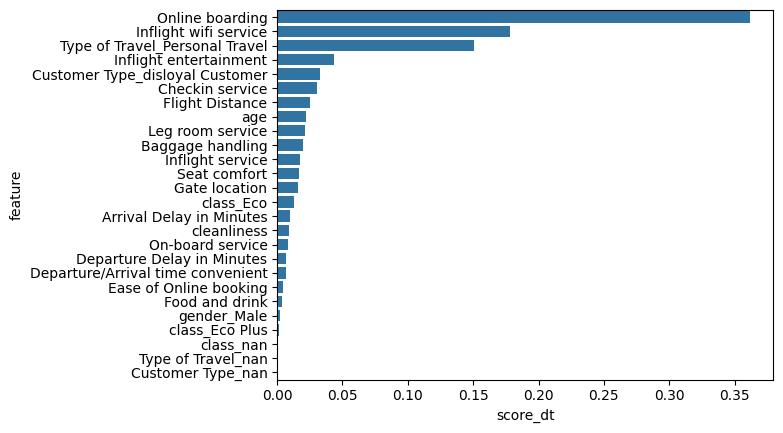

In [37]:
feature_importances = pd.DataFrame({
    "feature": X_train_ohe.columns,
    "importance": dt.feature_importances_
}).sort_values(by="importance", ascending=False)

sns.barplot(data=feature_importances, x=feature_importances['importance'], y=feature_importances['feature'])
plt.xlabel('score_dt')
plt.ylabel('feature')
plt.show()

Наиболее информативными признаками оказались Online boarding, Inflight wifi service

### **Задание 16. (0.1 балла)**

- Постройте дерево глубины 5, используя только 2 наиболее информативных признака для предыдущего построенного дерева.

In [63]:
X_train_2 = X_train_ohe[['Online boarding', 'Inflight wifi service']]
X_val_2 = X_val_ohe[['Online boarding', 'Inflight wifi service']]

dt_2 = DecisionTreeClassifier(max_depth=5, random_state=42)
dt_2.fit(X_train_2, y_train)
dt_2_pred = dt_2.predict(X_val_2)

accuracy_score(y_val, dt_2_pred)

0.8250918153200419

In [64]:
print(f"depth: {dt_2.get_depth()}")
print(f"leaves: {dt_2.get_n_leaves()}")

depth: 5
leaves: 20


Accuracy снизилось, но мы получили дерево всего глубиной 5 и с 20ю листьями, что намного лучше и меньше переобучения

### **Задание 17. (0.15 балла)**

- С помощью graphviz визуализируйте получившееся новое дерево решений. Почему предикаты в нем не целые, а кратны 1/2?

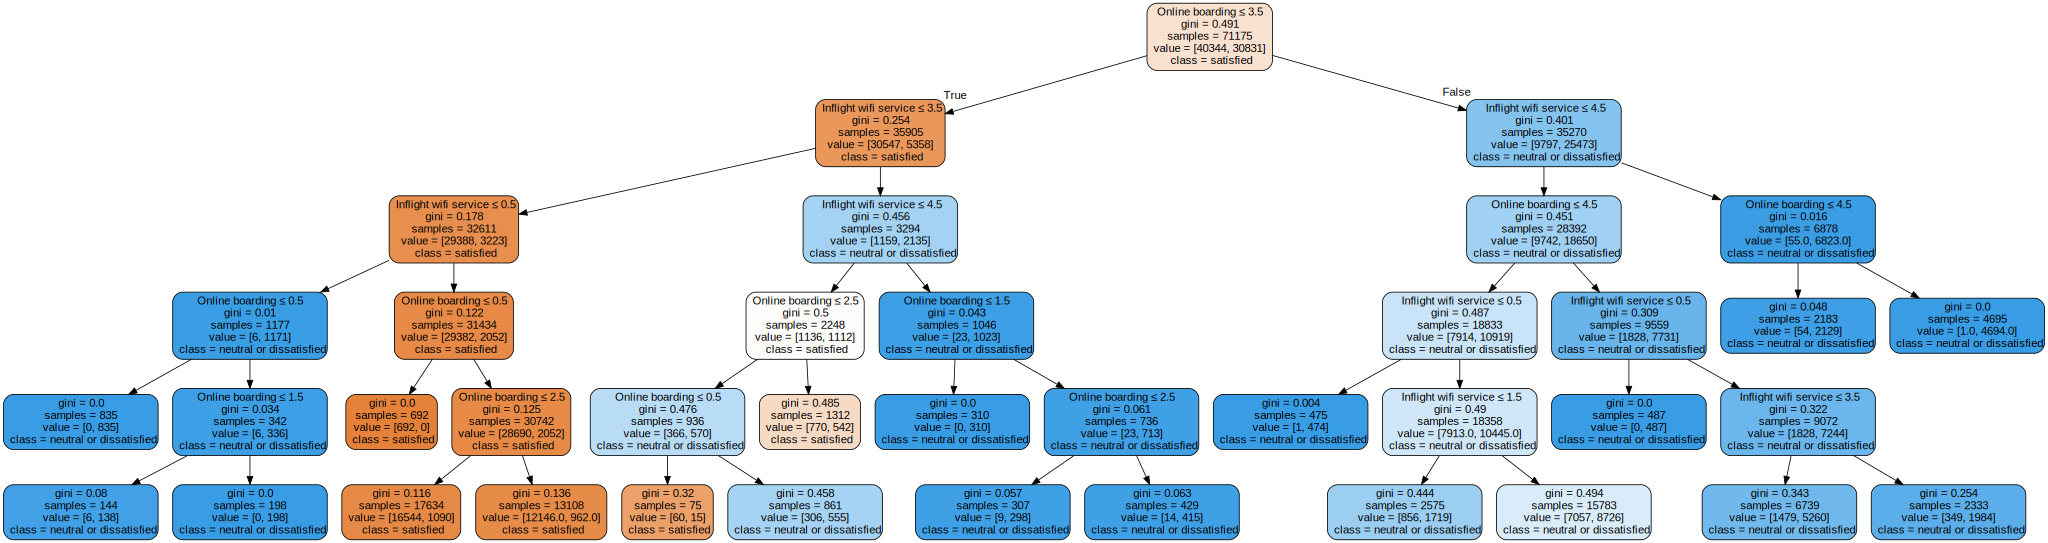

In [73]:
tree_data = export_graphviz(
    dt_2,
    out_file=None,
    feature_names=X_train_2.columns.tolist(),
    class_names=df_train['satisfaction'].unique().tolist(),
    filled=True,
    rounded=True,
    special_characters=True)

graph = Source(tree_data)
graph

`Ваш ответ здесь. `
Не нашла в интернете, но возможно у него под капотом для непрерывных признаков стратегия выбора оптимума находится как среднее значение между двумя соседними точками, и он эту стратегию сюда перенял, а тут значения категории целые, поэтому они всегда будут кратны 1/2.

### **Задание 18. (0.25 балла)**

- Теперь отобразите его функцией `plot_tree()` из sklearn.
- Проанализируйте — ссимметричным ли получилось дерево? И хорошо ли это, или нет?

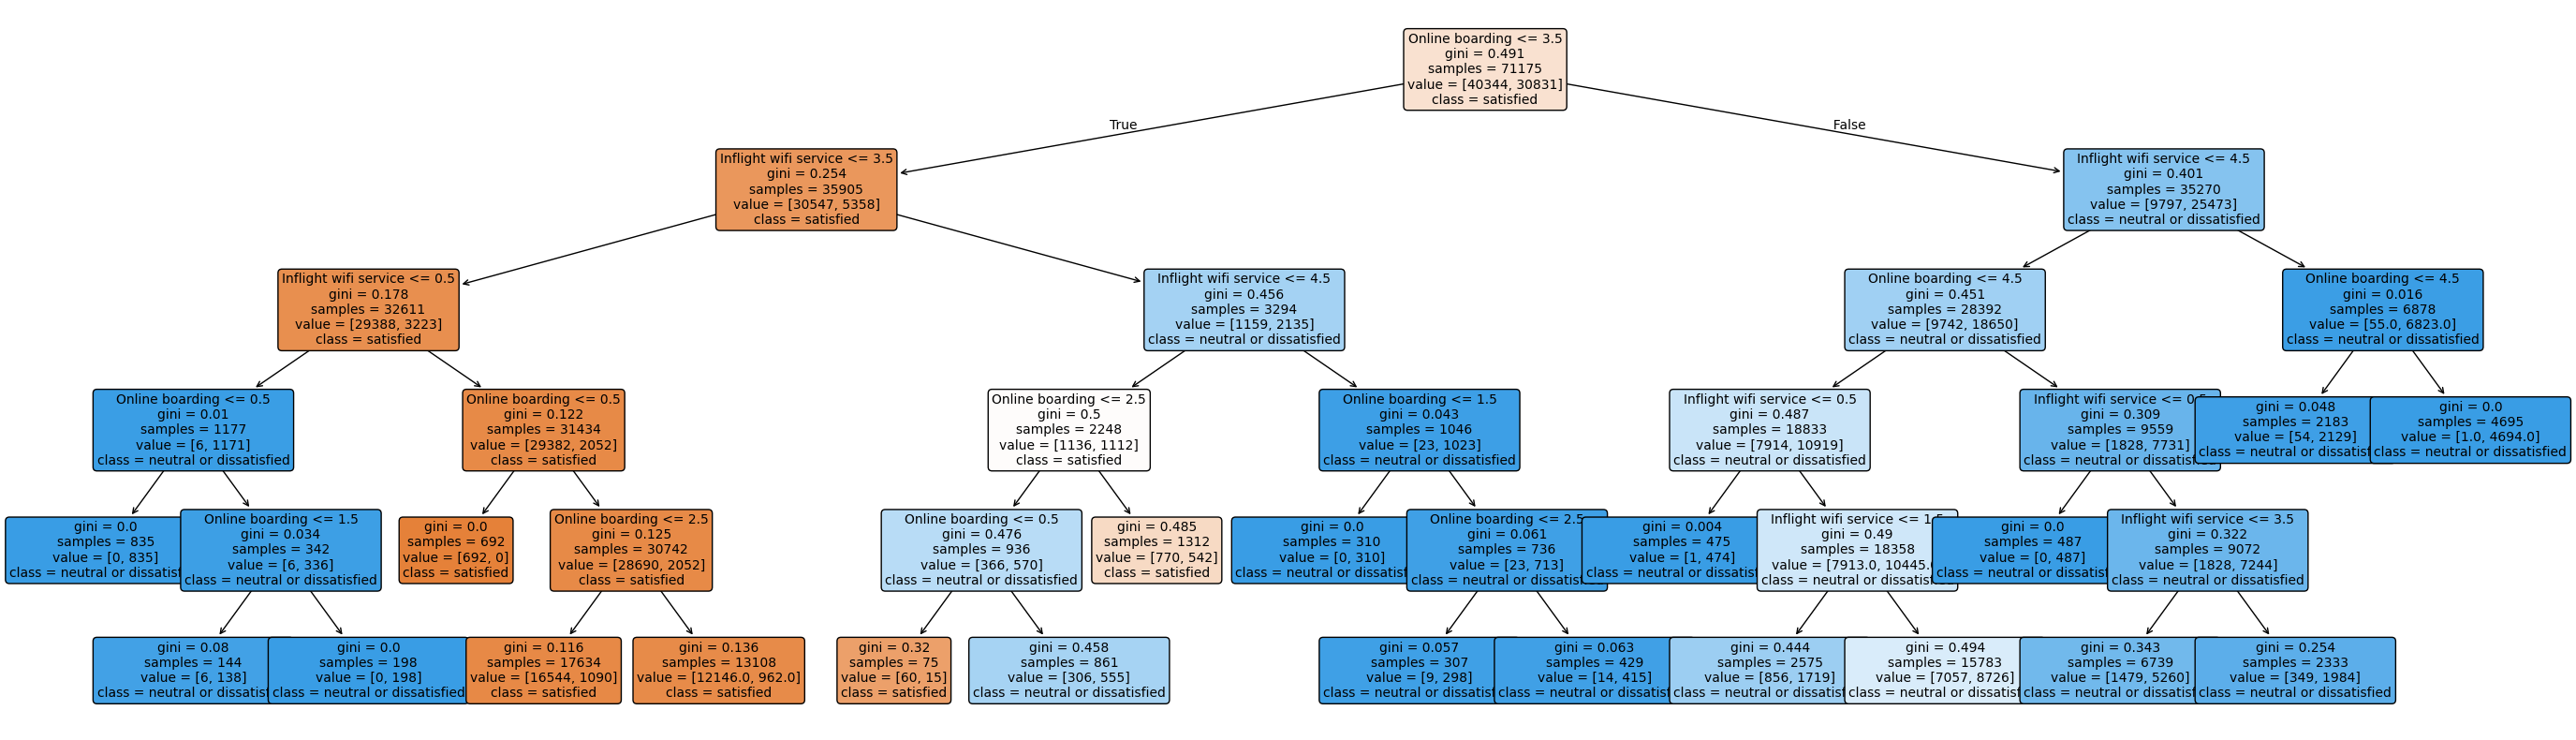

In [71]:
# Ваш код здесь
plt.figure(figsize=(35, 10))
plot_tree(
    dt_2,
    feature_names=X_train_2.columns.tolist(),
    class_names=df_train['satisfaction'].unique().tolist(),
    filled=True,
    rounded=True,
    fontsize=10)

plt.show()

Оно несимметричное, но больших прекосов в какую-то ветвь нет, поэтому нельзя скащать, что это плохо и оно переобучается

### **Задание 19. (0.5 балла)**

- Используя функцию `plot_decision_regions()` из `mlxtend`, отобразите разделяющую поверхность получившегося дерева. Отметьте на графике только первые 100 объектов обучающей выборки

In [80]:
X_train_2

Online boarding  Inflight wifi service
32590              2.0                    2.0
66281              2.0                    0.0
90429              3.0                    3.0
68777              5.0                    4.0
54906              5.0                    5.0
...                ...                    ...
7838               1.0                    1.0
68526              2.0                    2.0
96003              4.0                    4.0
1103               4.0                    4.0
19728              3.0                    3.0

[71175 rows x 2 columns]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


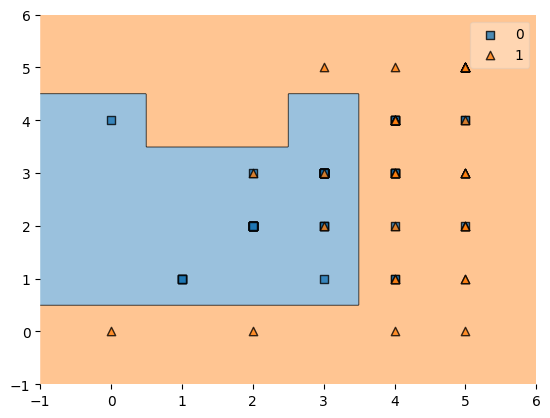

In [85]:
plot_decision_regions(clf=dt_2, X=X_train_2.iloc[:100, :].values, y=y_train[:100].values)
plt.show()

модель на некотрых объектах ошибается, получается

### **Деревья решений. Теоретическая вставка**

Из лекций вам должно быть известно, что деревья решений неустойчивы даже к небольшим изменениям в обучающей выборке. Попробуем показать это!

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/usr/local

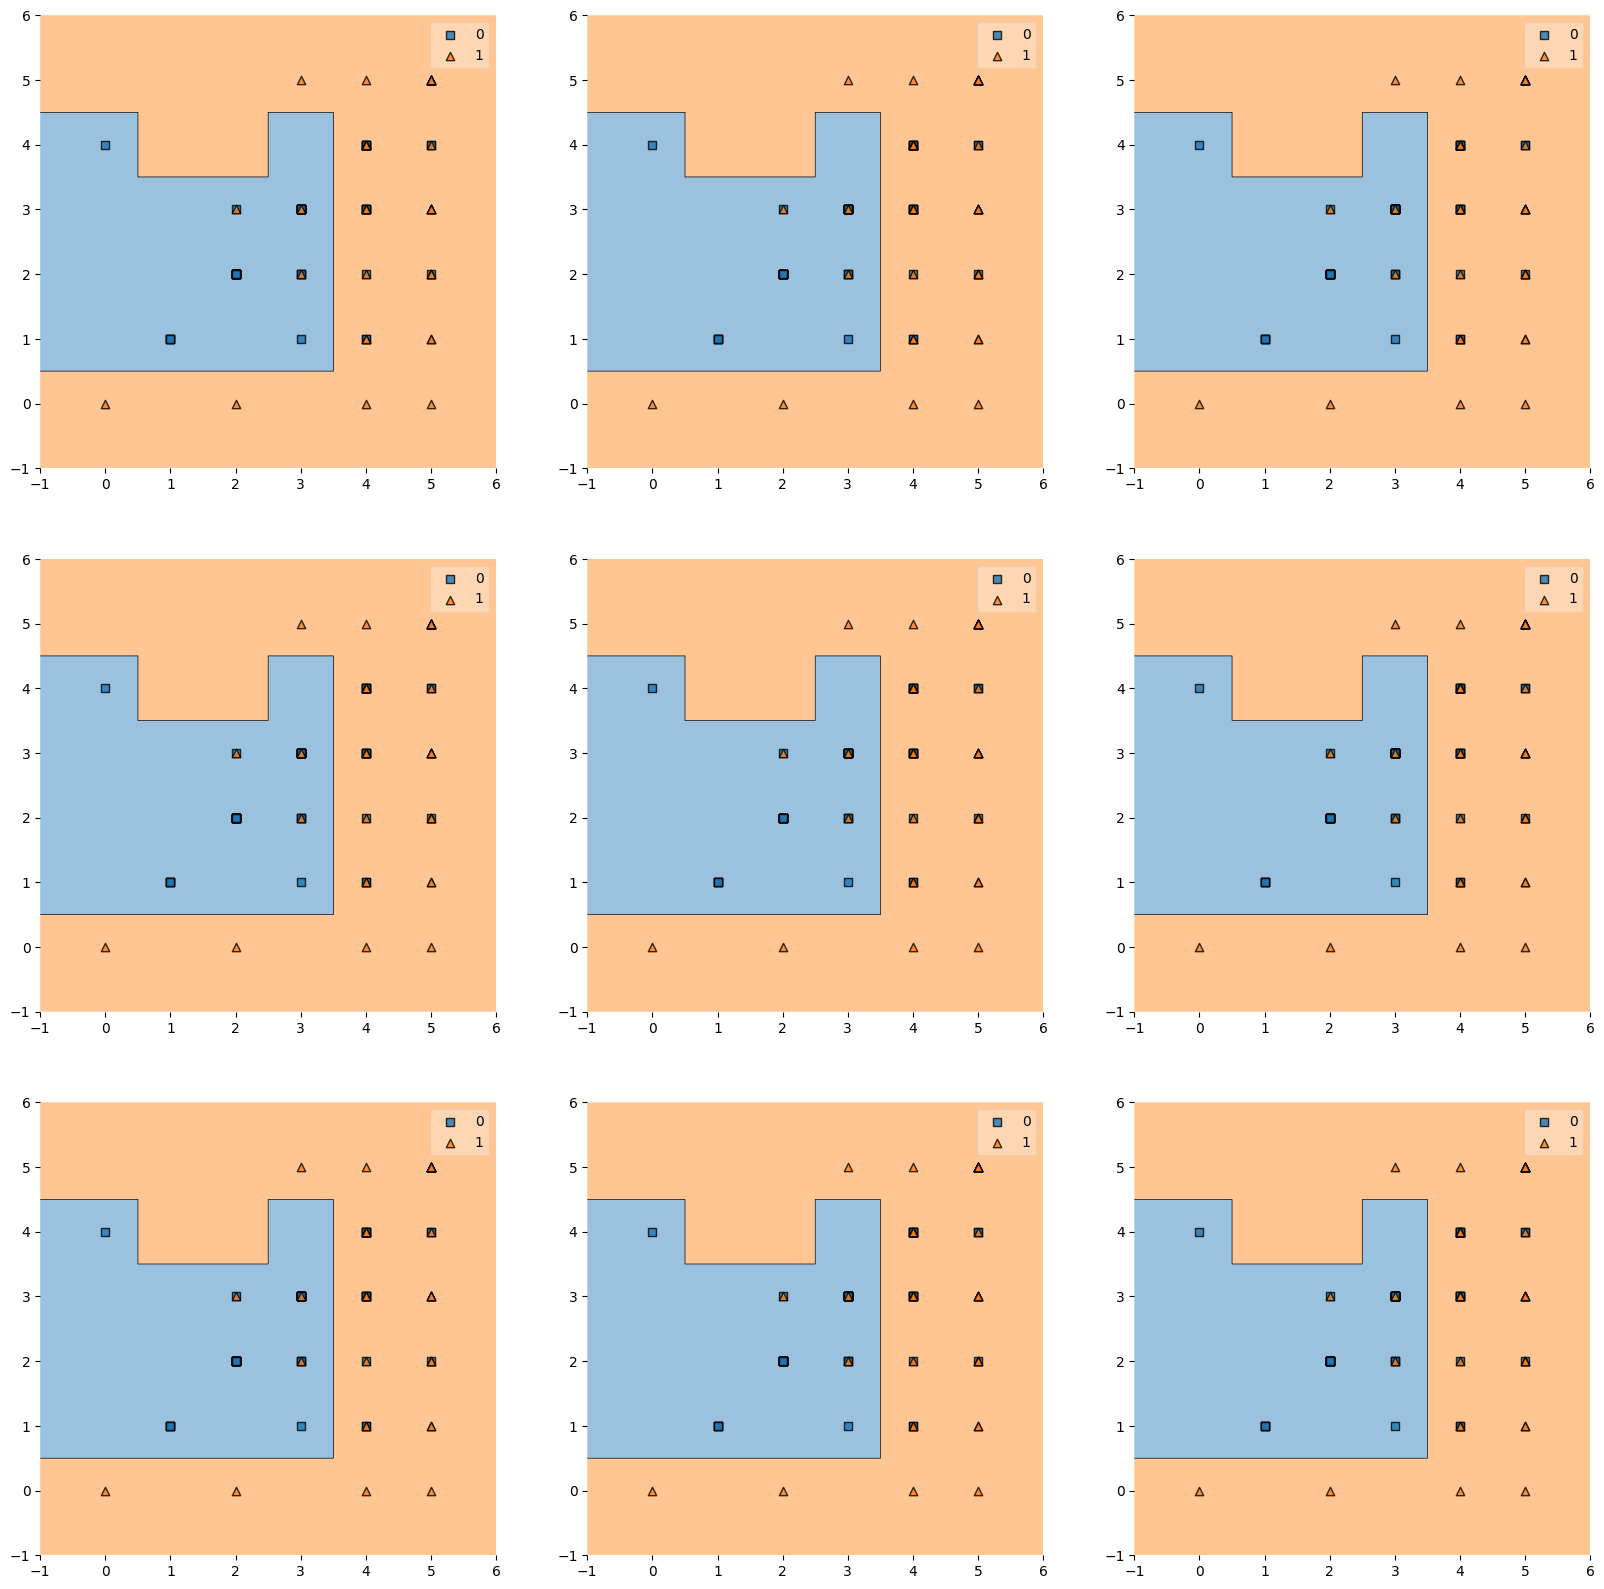

In [91]:
# замените X_train_example на вашу переменную

fig, ax = plt.subplots(3, 3, figsize=(20, 20))

for row in range(3):
    for col in range(3):
        inds = np.random.choice(X_train_2.index, size=X_train_2.shape[0] - 5000, replace=False) # нагляднее брать не на 1к, а на 5к меньше объектов, а то почти не изменяется разделяющая поверхность

        tree_exp = DecisionTreeClassifier(max_depth=5, random_state=42)
        tree_exp.fit(X_train_2.loc[inds, :], y_train[inds])

        plot_decision_regions(clf=tree_exp, X=np.array(X_train_2.iloc[:100, :]), y=np.array(y_train[:100]), ax=ax[row][col])

**Смотрите как двигается гранится, а ведь мы убирали из трейна (а в нем ~80к наблюдений) всего по тысяче случайных объектов!**

у меня вообще ничего не менялось с границей ни с 1к объектов, ни с 5к

Помимо своей неусточивости деревья решений "славны" ещё и склонностью к переобучению. Посмотрим, можно ли увидеть это свойство на имеющихся у нас данных. Для этого будем обучать алгоритм DT на всем трейне с разной глубиной дерева и считать accuracy для теста

In [92]:
# замените X_train_example на вашу переменную (ohe-encoded)

%%time
depths = [2, 3, 5, 10, 15, 20, 25, 32, 50, 64, 75, 100]

accuracies_train = []
accuracies_test = []
for max_depth in depths:
    DT = DecisionTreeClassifier(max_depth=max_depth, random_state=42)
    DT.fit(X_train_ohe, y_train)
    y_predicted_train = DT.predict(X_train_ohe)
    y_predicted_val = DT.predict(X_val_ohe)
    accuracies_train.append(accuracy_score(y_train, y_predicted_train))
    accuracies_test.append(accuracy_score(y_val, y_predicted_val))

CPU times: user 7.52 s, sys: 16.6 ms, total: 7.54 s
Wall time: 13.4 s


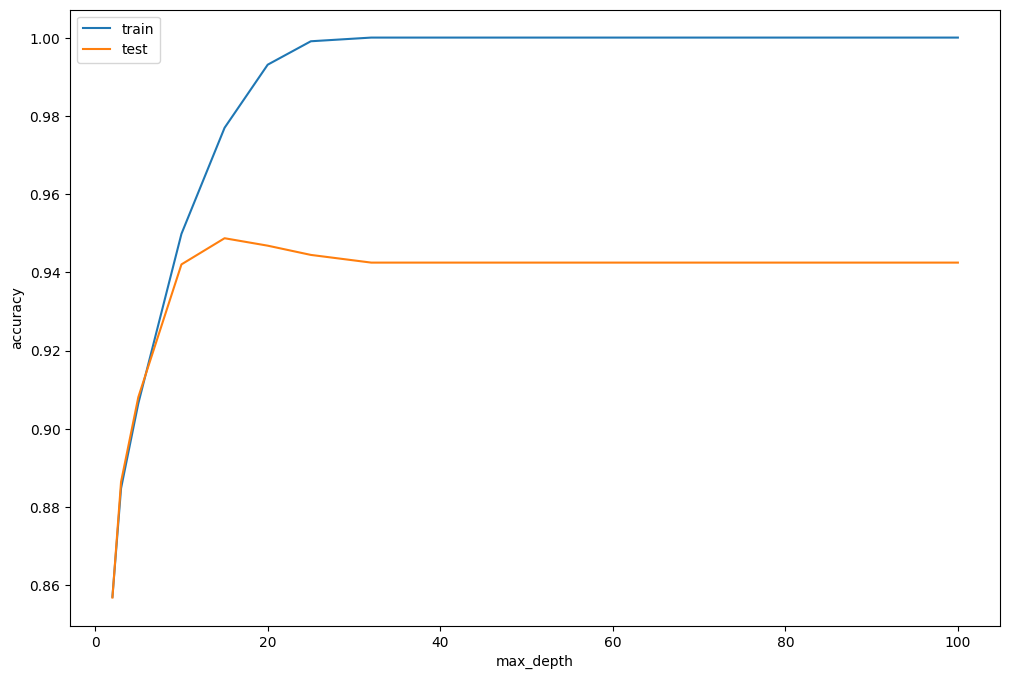

In [93]:
plt.figure(figsize=(12, 8))
plt.plot(depths, accuracies_train, depths, accuracies_test)
plt.legend(['train', 'test'])
plt.ylabel('accuracy')
plt.xlabel('max_depth')
plt.show()

Нам повезло выйти на ассимптоту на тесте. Однако так бывает далеко не всегда. Так что подбирать гипрепараметры для деревьев решений стоит осторожно

## **Возвращение к задаче**

### **Задание 20. (0.4 балла)**

- На кроссвалидации подберите оптимальные гиперпараметры для дерева решений *(по данным со всеми признаками -- не на модельном примере из теоретической вставки)*.
- Удалось ли улучшить качество предсказаний подбором гиперпараметров?

In [ ]:
# you know what to do
param_grid = {
    'max_depth': [3, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4, 6],
    'max_features': [None, 'sqrt', 'log2']
}


dt = DecisionTreeClassifier(random_state=42)
grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, cv=3, n_jobs=-1, verbose=1, scoring='accuracy')
grid_search.fit(X_train_ohe, y_train)

Fitting 3 folds for each of 180 candidates, totalling 540 fits


In [97]:
print(grid_search.best_params_)
best_model = grid_search.best_estimator_

{'max_depth': 15, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 10}


In [98]:
best_model.fit(X_train_ohe, y_train)
y_pred = best_model.predict(X_val_ohe)
print(accuracy_score(y_val, y_pred))

0.9497311122770199


Удалось улучшить на 0.5% accuracy

### **Задание 21. (0.1 балла)**

- Сохраните лучшее дерево в pickle

*Мы просим это сделать, чтобы вы в случае чего не тратили время на переобучение, а могли банально подгрузить из файла*

In [99]:
with open('DT.pkl', 'wb') as f:
  pickle.dump(best_model, f)

# **Часть 3. Random Forest (4.25 балла)**

### **Задание 22. (0.05 балла)**
- Обучите случайный лес с параметрами по умолчанию

In [22]:
# Ваш код здесь
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_ohe, y_train)
rf_pred = rf.predict(X_val_ohe)
accuracy_score(y_val, rf_pred)

0.9604866211962224

### **Задание 23. (0.15 балла)**
- Выведите калибровочную кривую для полученного ансамбля

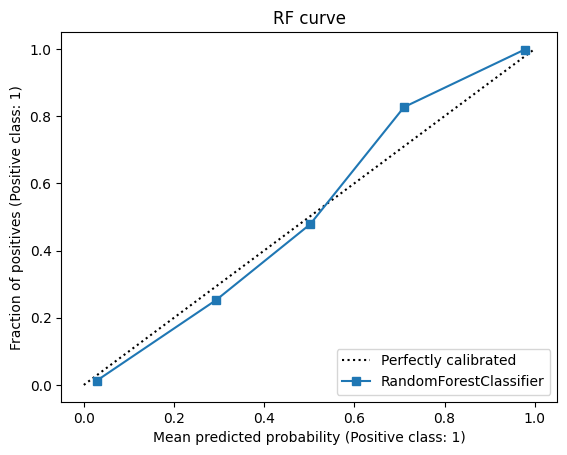

In [107]:
# Ваш код здесь
cd = CalibrationDisplay.from_estimator(rf, X_val_ohe, y_val, strategy='uniform')
plt.title("RF curve")
plt.show()

Похоже, мы немного недооцениваем высокие вероятности

<img src='https://habrastorage.org/r/w1560/getpro/habr/upload_files/510/4e0/63b/5104e063b62bd0ac6b87da44a3034aa5.png'>

Изображение взято из статьи ["predict_proba в Python не прогнозирует вероятности (и как с этим бороться)"](https://habr.com/ru/company/otus/blog/573924/) с Хабра

### **Задание 24. (0.4 балла)**

- Вспомните (или выведите), корректно ли деревья предсказывают вероятности?

Дерево не предсказывает вероятности по-настоящему, а просто считает сколько в узле было классов 1 и 0. Внутри одного узла всем объектам дают одну и ту же вероятность. Даже если один объект сильно отличается от другого, им всё равно дают одинаковую вероятность. И наоборот, если имеем два похожих объекта, но они попали в разные узлы, то и вероятность у них может принципиально отличаться, а так быть не должно


### **Задание 25. (0.15 балла)**
- Обучите логистическую регрессию так, чтобы она сошлась
- Отобразите её калибровочную кривую

In [15]:
lr = LogisticRegression(max_iter=5000, solver='saga', random_state=42)
lr.fit(X_train_ohe, y_train)
y_pred = lr.predict(X_val_ohe)
print(accuracy_score(y_val, y_pred))

0.624525631954718


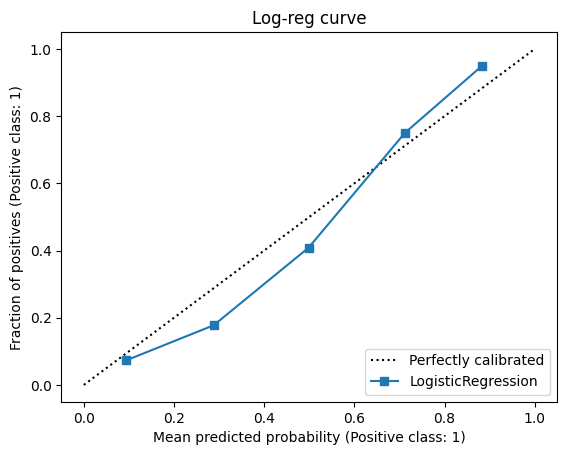

In [110]:
cd = CalibrationDisplay.from_estimator(lr, X_val_ohe, y_val, strategy='uniform')
plt.title("Log-reg curve")
plt.show()

Мы немного переоцениваем предсказанные низкие вероятности

### **Задание 26. (0.2 балла)**
- Покажите, почему считается, что логистическая регрессия корректно предсказывает вероятности?

Она минимизирует логарифмическую функцию потерь, которая измеряет расхождение между предсказанными вероятностями и истинными метками классов (кросс-энтропия)


### **Задание 27. (0.35 балла)**

Предлагаем вам попробовать откалибровать вероятности обученного случайного леса!

- Откалибруйте вероятности, при помощи логистической и изотонической регрессий.
- Интерпретируйте полученные результаты

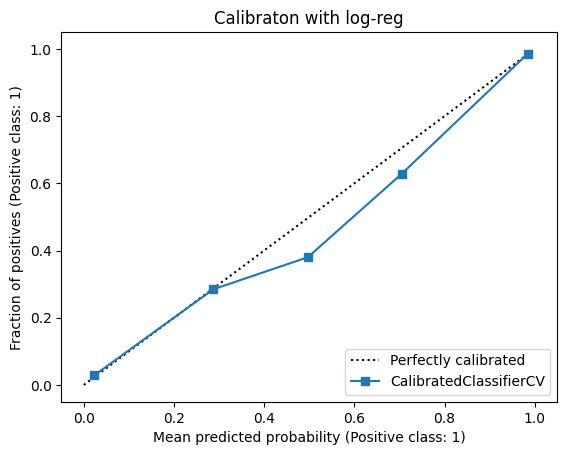

In [113]:
from sklearn.calibration import CalibratedClassifierCV
calibrated_rf_sigmoid = CalibratedClassifierCV(estimator=rf, method='sigmoid', cv=3)
calibrated_rf_sigmoid.fit(X_train_ohe, y_train)

cd = CalibrationDisplay.from_estimator(calibrated_rf_sigmoid, X_val_ohe, y_val, strategy='uniform')
plt.title("Calibraton with log-reg")
plt.show()

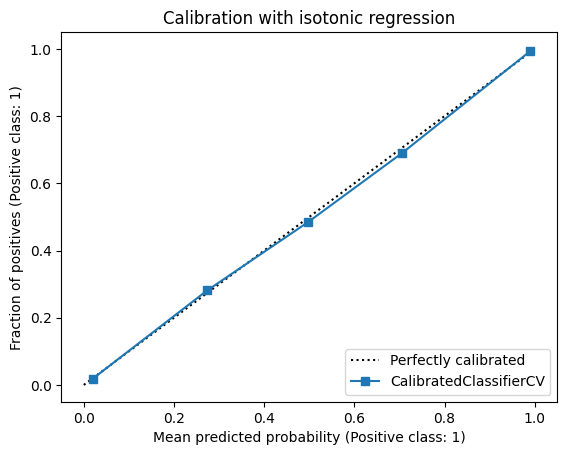

In [114]:
calibrated_rf_isotonic = CalibratedClassifierCV(estimator=rf, method='isotonic', cv=3)
calibrated_rf_isotonic.fit(X_train_ohe, y_train)

cd = CalibrationDisplay.from_estimator(calibrated_rf_isotonic, X_val_ohe, y_val, strategy='uniform')
plt.title("Calibration with isotonic regression")
plt.show()

Изотоническая регрессия дает лучше результат чем логрег

### **Задание 28. (0.2 балла)**
- Опишите другие возвожные подходы к калибровке вероятностей (со ссылками на источники)

Гистограммная калибровка

Делит диапазон предсказанных вероятностей на интервалы (бины) и заменяет предсказанные значения на средние фактические частоты в этих интервалах.

Калибровка Платта представляет собой по сути применение сигмоиды поверх другой модели (то есть самый наивный способ получения «вероятностей»).

Источник: https://education.yandex.ru/handbook/ml/article/kak-ocenivat-veroyatnosti?utm_source=chatgpt.com

### **Задание 29. (0.5 баллa)**

Проанализируйте лес.
- Посчитайте разброс и смещение полученного случайного леса (до калибровки).
- Оличаются ли они от полученных для дерева решений?
- Соответствуют ли полученные на реальных данных отличия (//совпадения) от тех, что должны быть в теории? По каким причинам?

In [118]:
error_rf, bias_rf, var_rf = bias_variance_decomp(rf, X_train_ohe.values[:1000], y_train.values[:1000],
                                                 X_val_ohe.values[:1000], y_val.values[:1000],
                                                 loss='0-1_loss',
                                                 random_seed=42)
error_rf, bias_rf, var_rf

(0.0696075, 0.0655, 0.020072499999999997)

Посмотрела только на 1000, потмоу что большо 30 минут грущилось и не прогурзилось.
Итог: у случайного леса меньше разброс, что подтверждается теорией, смещение осталось примерно таким же, ошибка тоже

### **Задание 30. (0.5 баллa)**

- Вычислите разложение ошибки для логистической регрессии (ванильной, которую вы обучили для решения задачи в задании 25, а не той, что использовали для калибровки)
- Сравните полученные результаты с предыдущими.
- Объясните природу этих результатов

In [22]:
# Ваш код здесь
logreg_model = LogisticRegression(max_iter=1000, solver='lbfgs', random_state=42, n_jobs=-1)
logreg_model.fit(X_train_ohe[:1000], y_train[:1000])


error_logreg, bias_logreg, var_logreg = bias_variance_decomp(
    logreg_model,
    X_train_ohe.values[:1000], y_train.values[:1000],
    X_val_ohe.values[:1000], y_val.values[:1000],
    loss='0-1_loss',
    random_seed=42
)


error_logreg, bias_logreg, var_logreg

(0.12729, 0.119, 0.033510000000000005)

Все компоненты выше чем у случайного леса. Это может объяснятся нелинейными зависимостями в данных, а также тем, что для случайного леса по его построению смещение и разброс меньше чем для линейной модели

### **Задание 31. (0.8 баллa)**

- Попробуйте подобрать оптимальные гиперпараметры леса, используя [RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html).

**Важно:**  

Хотя бы один из гиперпараметров перебирайте из распределения (например, `uniform` из `scipy.stats`)

In [28]:
# Ваш код здесь
from scipy.stats import uniform, randint

rf = RandomForestClassifier(random_state=42)
params = {
    'n_estimators': randint(10, 50),  # количество деревьев
    'max_depth': [5, 10, 20, 40],         # максимальная глубина деревьев
    'min_samples_split': uniform(0.1, 0.9),  # доля от выборки (из непрерывного распределения)
    'min_samples_leaf': uniform(0.1, 0.9),  # минимальное количество эл-ов в листьях в долях
    'max_features': ['sqrt', 'log2', None]  # количество признаков для узлов
}

random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=params,
    n_iter=30,
    cv=3,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train_ohe, y_train)
print("Лучшие параметры:", random_search.best_params_)

Лучшие параметры: {'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 0.10635967469774567, 'min_samples_split': 0.12075618253727419, 'n_estimators': 36}


In [31]:
rf_r = random_search.best_estimator_
y_pred = rf_r.predict(X_val_ohe)
print(accuracy_score(y_val, y_pred))

0.8604875538689136


Accuracy по сравнению с дефолтными гиперпарметрами улучшить не удалось

## **Случайный лес. Вставка теории**

На модельном примере посмотрим, склонен ли случайный лес к переобучению с ростом числа деревьев в композиции.

Возьмем 4 полезных признака из одного из предыдщущих заданий, напоминающих теорию

In [32]:
# замените X_train_enc на ваш трейн

cols_for_RF = ['age', 'Flight Distance', 'Online boarding', 'Inflight wifi service']
X_train_RF = X_train_ohe[cols_for_RF]
# а тест нам не понадобится, ведь можно получить OOB-estimate ошибки

clf = RandomForestClassifier(warm_start=True, oob_score=True, random_state=42)
errors = []

for n_estimators in range(1, 251, 5):
    clf.set_params(n_estimators=n_estimators)
    clf.fit(X_train_RF, y_train)

    errors.append(1 - clf.oob_score_)

/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too fe

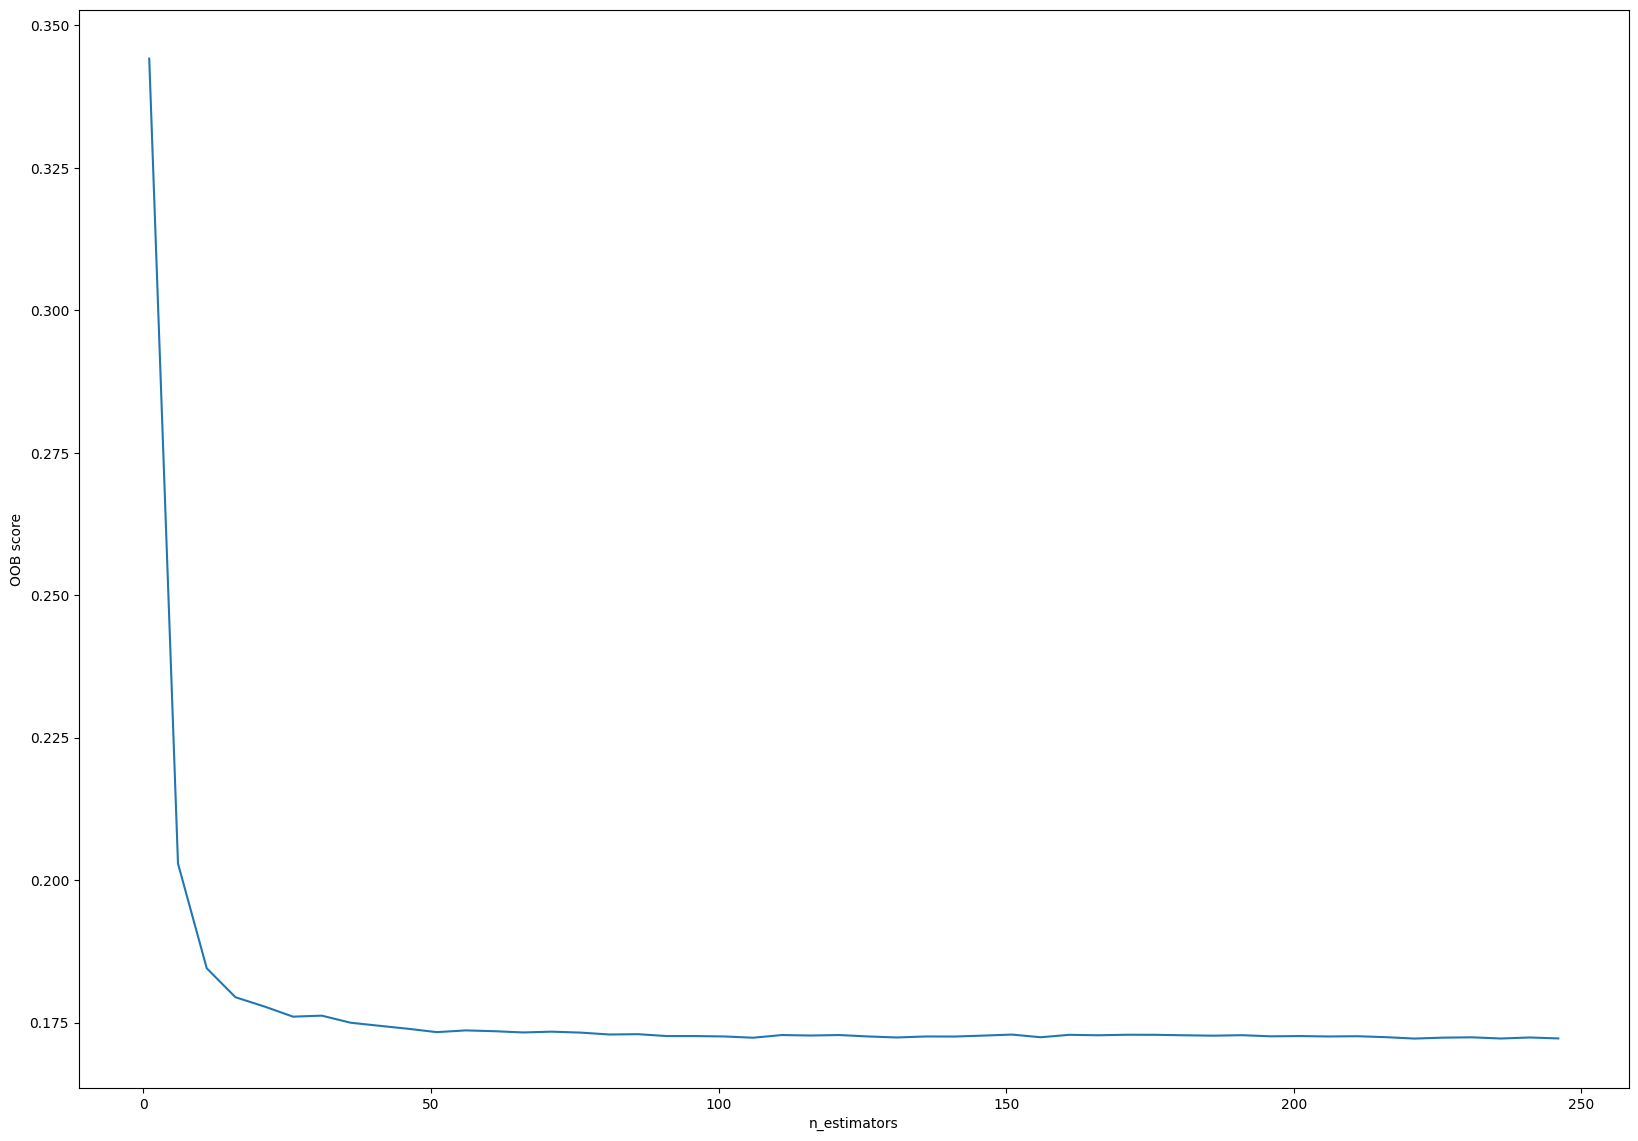

In [33]:
plt.figure(figsize=(20, 14))
plt.plot(range(1, 251, 5), errors)

plt.xlabel('n_estimators')
plt.ylabel('OOB score')
plt.show()

**Дисклеймер**: отсутствие переобучения с ростом числа деревьев вовсе не означает, что сама модель случайного леса не может быть переобучена. Базовые деревья такой композиции могут переобучаться. Значит, и вся композиция вполне способна оказаться переобученной

## **Возвращение к задаче**

### **Задание 32. (0.6 баллa)**

- Отобразите`feature_importances_` вашего лучшего случайного леса
- Сравните важности признаков для дерева решений и для случайного леса. Постройте диаграмму


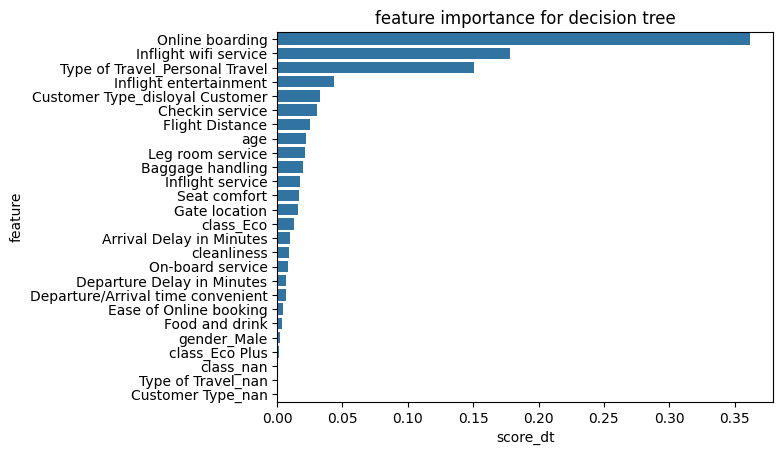

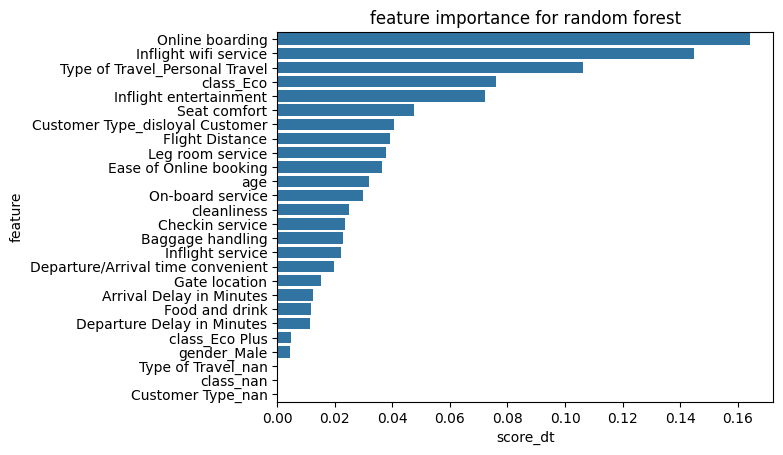

In [40]:
sns.barplot(data=feature_importances, x=feature_importances['importance'], y=feature_importances['feature'])
plt.title('feature importance for decision tree')
plt.xlabel('score_dt')
plt.ylabel('feature')
plt.show()

feature_importances_rf = pd.DataFrame({
    "feature": X_train_ohe.columns,
    "importance": rf.feature_importances_
}).sort_values(by="importance", ascending=False)

sns.barplot(data=feature_importances_rf, x=feature_importances_rf['importance'], y=feature_importances_rf['feature'])
plt.title('feature importance for random forest')
plt.xlabel('score_dt')
plt.ylabel('feature')
plt.show()

2 наиболее важных признака для случайного леса точно такие же, как для дерева решений, но с меньшей важностью. Дерево решений фокусируется на нескольких основных признаках, а случайный лес распределяет значимость между многими переменными

### **Задание 33. (0.1 баллa)**

- Случайный лес, дающий лучший скор, [сохраните в pickle](https://scikit-learn.ru/stable/model_persistence.html)

In [34]:
with open('RF.pkl', 'wb') as f:
 pickle.dump(rf, f)

### **Задание 34. (0.25 балла)**
- Интерпретируйте важности признаков с помощью SHAP.
- Опишите полученый график

**Важно:** Для подсчета используйте 1000 случайных объектов, иначе не дождетесь за приемлемое время

**Вам может помочь:** [Статья "Интерпретация моделей и диагностика сдвига данных: LIME, SHAP и Shapley Flow"](https://habr.com/ru/company/ods/blog/599573/) из блога ods.ai на Хабре

`Ваш ответ здесь`

In [23]:
df_sample = X_train_ohe.sample(1000, random_state=42)
explainer_rf = shap.TreeExplainer(rf)
shap_values_rf = explainer_rf.shap_values(df_sample)

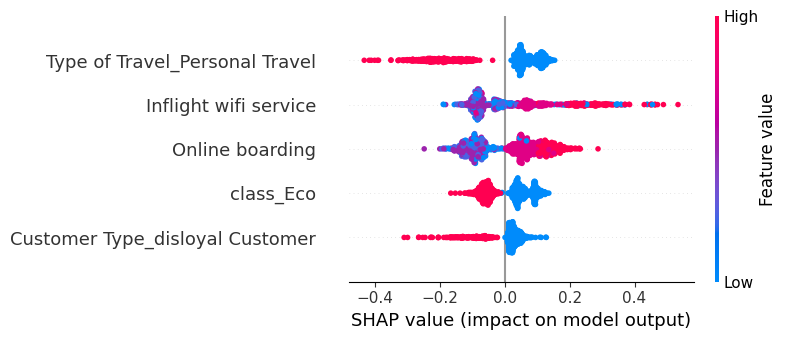

In [27]:
shap.summary_plot(shap_values_rf[:, :, 1], df_sample, max_display=5)

Вывела топ-5 по вкладу в прогноз вероятности
- личные поездки увеличивают вероятность неудовлетворенности полетом
- качество wifi увеличивает вероятность удовлетворенности полетом, вклад больше, чем у маленьких значений
- наличие онлайн-брони все же кажется чуть-чуть дает положиткльный вклад в удовлетворенность полетом
- эко класс дает увеличивает вероятность неудовлетворенности полетом
- если клиент нелояльный, то это увеличивает вероятность в неудовлетворенность полетом

### **Бонус (0.1 балл)**

- Изучите документацию библиотеки SHAP. Что ещё полезного в ней имеется?

Объяснители разные:
- DeepExplainer: предназначен для глубоких нейронных сетей
- KernelExplainer: универсальный метод, подходящий для любых моделей

визуализации:
- Force Plot: показывает влияние каждого признака на конкретное предсказание, помогая понять индивидуальные решения модели
- Waterfall Plot: иллюстрирует последовательное влияние признаков, показывая, как каждый из них увеличивает или уменьшает итоговое предсказание

### **Бонус (0.5 балла)**

- Интерпретируйте важности признаков для одного прогноза с помощью LIME;
- Опишите полученный график для выбранного наблюдения

In [46]:
import numpy as np
from lime.lime_tabular import LimeTabularExplainer

# Подготовка данных
class_names = np.unique(y_train).astype(str)

explainer = LimeTabularExplainer(
    training_data=np.array(X_train_ohe),
    feature_names=X_train_ohe.columns,
    class_names=class_names,
    mode='classification'
)

observation = np.array(X_train_ohe.iloc[0, :])
explanation = explainer.explain_instance(
    data_row=observation,
    predict_fn=rf.predict_proba,
    num_features=10
)
explanation.show_in_notebook()


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Модель уверена, что данный объект относится к удовлетвореному полетом клиенту
Основные признаки, которые повлияли на предсказание:
- Type of Travel_Personal Travel (оранжевая полоса): увеличило вероятность класса 1.
- Customer Type_disloyal Customer (синяя полоса): уменьшило вероятность класса 1.
- Online Boarding уменьшило вероятность класса 1
Класс 1 - это satisfied


`Ваш ответ здесь`

## Котобонус!

0.25 балла

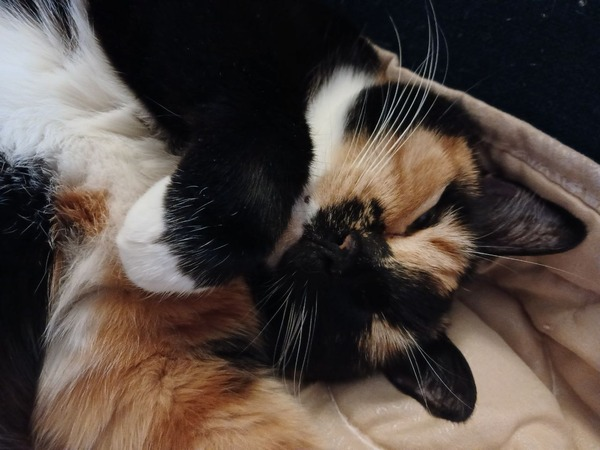

Кот Елены

# Обратная связь

Расскажите, как вам это домашнее задание. Было ли оно полезным? Научились ли вы чему то? Насколько сложным по 10-балльной шкале оно вам показалось? Сколько времени у вас ушло на его выполнение? Что следовало ещё в него включить? Было ли что-то лишнее?

Пока у меня снова виснет вычисление ошибки, разброса, и смещения буду писать отзыв: зачем нам строить 30 графиков, а потом смотреть это же в sns pairplot? на мой взгляд, лишнее. Очень долго все считается, логрег 10 минут обучался, до этого падал, разложение ошибки тоже.

В целом, спасибо